<a href="https://colab.research.google.com/github/faberc/ee510/blob/main/Resampling_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from IPython.core.display import HTML
HTML("<script>MathJax.Hub.Config({displayAlign: 'left'});</script>")

In [2]:
!git clone https://github.com/faberc/ee510.git

Cloning into 'ee510'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [3]:
!cp /content/ee510/jupyter/* .

In [4]:
%%capture
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!sudo apt install cm-super

In [5]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy import signal
import scipy

plt.rcParams['text.usetex'] = True

In [6]:
def AddColorbar(axes,colorMap='gray'):
    images = axes.get_images()
    if len(images) > 0:
       vmin, vmax = images[0].get_clim()
    sm = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vmin,vmax=vmax),cmap=colorMap)
    bb = np.array(axes.get_position().bounds)
    bb[0] += bb[2]*0.95
    bb[2] *= 0.05
    
    barAxes = figure.add_axes(bb)
    figure.colorbar(sm,barAxes)

In [7]:
def GetTestImage(nPixelsPerSide=25):
    iHalf = int(nPixelsPerSide/2)
    i14   = int(nPixelsPerSide*1/4)
    i34   = int(nPixelsPerSide*3/4)
    #image = np.ones((nPixelsPerSide,nPixelsPerSide),np.float32)*0.2
    image = np.zeros((nPixelsPerSide,nPixelsPerSide),np.float32)
    image[iHalf,:] = 1.0
    image[:,iHalf] = 1.0
    image[iHalf:,i34] = 1.0
    image[i34,iHalf:] = 1.0
    image[i14,i34] = 1.0
    image[i34:,i34:] = 1.0
    for c in range(iHalf): 
        image[c,c] = 1.0
        image[-1-c,c] = 1.0
    return(image)

In [8]:
def GetImpulseImage(nPixelsPerSide=25):
    iHalf = int(nPixelsPerSide/2)
    image = np.zeros((nPixelsPerSide,nPixelsPerSide),np.float32)
    image[iHalf,iHalf] = 1.0
    return(image)

In [9]:
def GetChirpImage(nPixelsPerSide,fMax=0.4):
    iv = np.arange(nPixelsPerSide) 
    iv = iv.reshape(-1,1)
    irows = iv*np.ones((1,nPixelsPerSide))
    icols = np.transpose(irows)
    image = signal.chirp(irows,0,irows.max(),fMax)*signal.chirp(icols,0,icols.max(),fMax)
    return(image)

In [10]:
def Kernel(t,t0,kernelType='Sinc',parameter=np.nan):
    td = t - t0
    if kernelType=='Sinc':
        x = np.sinc(td)
    elif kernelType=='Windowed Sinc':
        # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window
        # for a list of over a dozen different windows that might be used. However, these are discrete-time
        # windows and this function has to work for real-valued values, so you'll need to code in whatever
        # window you want to use yourself
        windowDuration = 5
        window = (1-(td/windowDuration)**2)**2*(np.abs(td)<windowDuration) # Biweight window    
        x = np.sinc(td)*window
    elif kernelType=='Gaussian': # Linear interpolation
        sigma = 0.5425 # Closely matches that used by pyrUp and pyrDown in OpenCV
        if not np.isnan(parameter):
            sigma = parameter
        k = int(np.ceil(np.abs(td).min()))
        n = np.arange(-k,k+1)
        xn = np.exp(-(n**2.0)/(2*sigma**2.0))
        x = np.exp(-(td**2.0)/(2*sigma**2.0))/sum(xn)
    elif kernelType=='Tent': # Linear interpolation
        a = -0.5
        x = (1-np.abs(td))*(np.abs(td)<1)   
    elif kernelType=='Cubic Basis':
        a = -1.0
        ua = td+2
        ub = td+1
        uc = td
        ud = td-1
        x  = (1/6)*(ua)**3                 *(0<=ua)*(ua<1) 
        x += (1/6)*(1+3*ub+3*ub**2-3*ub**3)*(0<=ub)*(ub<1)
        x += (1/6)*(4-6*uc**2+3*uc**3)     *(0<=uc)*(uc<1)
        x += (1/6)*(1-ud)**3               *(0<=ud)*(ud<1)
    elif kernelType=='Quadratic Interpolant':
        # This is an inefficient and lazy implementation, but mathematically
        # will produce the same result as a normal cubic spline
        # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
        # for a list of other types (kinds) of interpolation
        x = np.arange(-200,200)
        y = (x==0)
        function = scipy.interpolate.interp1d(x, y, kind='quadratic')
        x = function(td)        
    elif kernelType=='Cubic Interpolant':
        # This is an inefficient and lazy implementation, but mathematically
        # will produce the same result as a normal cubic spline
        # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
        # for a list of other types (kinds) of interpolation
        x = np.arange(-200,200)
        y = (x==0)
        function = scipy.interpolate.interp1d(x, y, kind='cubic')
        x = function(td)
    elif kernelType=='Cubic':
        a = -1.0
        x = (1-(a+3)*td**2 + (a+2)*np.abs(td)**3)*(np.abs(td)<1)
        x += a*(np.abs(td)-1)*(np.abs(td)-2)**2.0*(1<=np.abs(td))*(np.abs(td)<2)        
    elif kernelType=='Cubic (Quadratic Reproducing)':
        a = -0.5
        x = (1-(a+3)*td**2 + (a+2)*np.abs(td)**3)*(np.abs(td)<1)
        x += a*(np.abs(td)-1)*(np.abs(td)-2)**2.0*(1<=np.abs(td))*(np.abs(td)<2)
    return(x)

In [11]:
def UpsampleImage(image,upsample=2,kernelName='Cubic (Quadratic Reproducing)',parameter=np.nan):
    order = upsample*4+1

    n = np.arange(-(order-1)/2,(order-1)/2+1)/upsample
    kv = Kernel(n,0,kernelType=kernelName,parameter=parameter)
    kv = kv.reshape(-1, 1)
    kh = np.transpose(kv)

    imageRowUp = np.zeros((image.shape[0]*upsample,image.shape[1]),dtype='float')
    imageRowUp[::upsample] = image

    imageRowFiltered = cv.filter2D(imageRowUp,-1,kv,) 

    imageColUp = np.zeros((imageRowFiltered.shape[0],image.shape[1]*upsample),dtype='float')
    imageColUp[:,::upsample] = imageRowFiltered

    imageColFiltered = cv.filter2D(imageColUp,-1,kh) 
    
    return(imageColFiltered)

In [12]:
def GetAntialiasingKernel(kernelName=None):
    kernels = dict()

    nh = 9 # The larger this is, the sharper the frequency response but the greater the computation and edge effects

    # The following are one sided impulse responses for the non-negative delays/offsets only
    # See Table 3.4, Page 131, in Szeliski's Computer Vision, Version 1 
    kernels['Impulse'      ] = np.array([1.0]) # This doesn't filter at all
    kernels['Linear'       ] = np.array([0.50,0.25])
    kernels['Binomial'     ] = np.array([0.375,0.25,0.0625])
    kernels['Cubic'        ] = np.array([0.5,0.28125,0,-0.03125])
    kernels['Windowed Sinc'] = np.array([0.4939,0.2684,0,-0.0153])
    kernels['QMF-9'        ] = np.array([0.5638,0.2932,-0.0519,-0.0431,0.0198])
    kernels['JPEG20009'    ] = np.array([0.6029,0.2669,-0.0782,-0.0169,0.0267])
    kernels['Sinc'         ] = np.sinc(0.5*np.arange(0,nh))
    kernels['OpenCV'       ] = np.array([6.0,4.0,1.0])
    
    halfWindow = scipy.signal.windows.get_window('hamming',nh+1)[int((nh+1)/2):]
    kernels['Hamming Sinc'] = np.sinc(0.5*np.arange(0,(nh+1)/2))*halfWindow
    
    if kernelName is None:
        return(list(kernels.keys()))
    
    h  = kernels[kernelName]
    h  = np.concatenate((h[::-1],h[1:])) # Convert into an odd length symmetric impulse response
    h /= h.sum() # Ensure DC gain is 1
    n  = np.arange(-int((len(h)-1)/2),int((len(h)+1)/2))
    return h,n

In [13]:
def DownsampleImage(image,kernelName='JPEG20009'):
    # Only downsamples by 2 - no other downsample rates supported
    kernel,n = GetAntialiasingKernel(kernelName)
    kernel = kernel.reshape(-1,1) # Convert to matrix
    kernel = np.matmul(kernel,np.transpose(kernel)) # Make into a 2D Kernel

    antialiased = cv.filter2D(image.astype('float32'),cv.CV_32F,kernel)
    decimated   = antialiased[::2,::2]
    
    return(decimated)

In [14]:
def SymmetricKernelDTFT(kernel):
    kernelSize = len(kernel)
    omega = np.linspace(0,np.pi,1000)
    ns = np.arange(-(kernelSize-1)/2,(kernelSize-1)/2+1)
    H = np.zeros_like(omega)
    
    offset = int((kernelSize-1)/2)
    for n in ns:
        H = H + kernel[int(n)+offset]*np.cos(omega*n)
    return omega,H

# Resampling
* We often need to change the resolution (number of pixels per side) of an image
* This may involve either increasing or decreasing the number of pixels
* There are many applications of being able to do this
    * Matching the resolution between two different images so they can be compared more easily
    * Reducing computation
* Appropriate resolution may not even be known
* Suppose we want to find a face in an image
* We have no idea if the face is in a small or large part of the image
* The scale is unknown
* Usually this means we have to search at all scales
* The notion of scale isn't often used in signal processing
* Is very important in image processing and computer vision
* Much more efficient (computationally) to reduce the number of pixels when looking at large scales with large features
* Thus, we need to be able to increase or decrease the size of an image
* Increasing the size of an image is called _interpolation_
* Decreasing the size of an image is called _decimation_
* Once we have this ability we can go up or down in size easily
* If we want to search across different scales, we can create a hierarchy of images at different scales
* Called _image pyramids_

## Interpolation

* Interpolation is done essentially the same way that we interpolate signals
* Recall that if we want to convert a discrete-time signal to a continuous-time signal, the proper way is to use band-limited interpolation

$
\begin{align}
    x(t) &= \frac{T_s \omega_c}{\pi}\sum_{n=-\infty}^{\infty} h[n] \mathrm{sinc}\left(\omega_c (t-nT_s)\right)
\end{align}
$

where $\omega_c$ is the cutoff frequency and $T_s$ is the sampling interval, and

$
\mathrm{sinc}(t) = \frac{\sin(\pi t)}{\pi t}
$

* Note that in the limit you would pick $\omega_c = \frac{2\pi}{T_s}$.

* However, we don't have to use a sinc function
* The sinc function is the only correct function from the standpoint of reconstructing the original signal
* But other functions are possible and are used in image processing


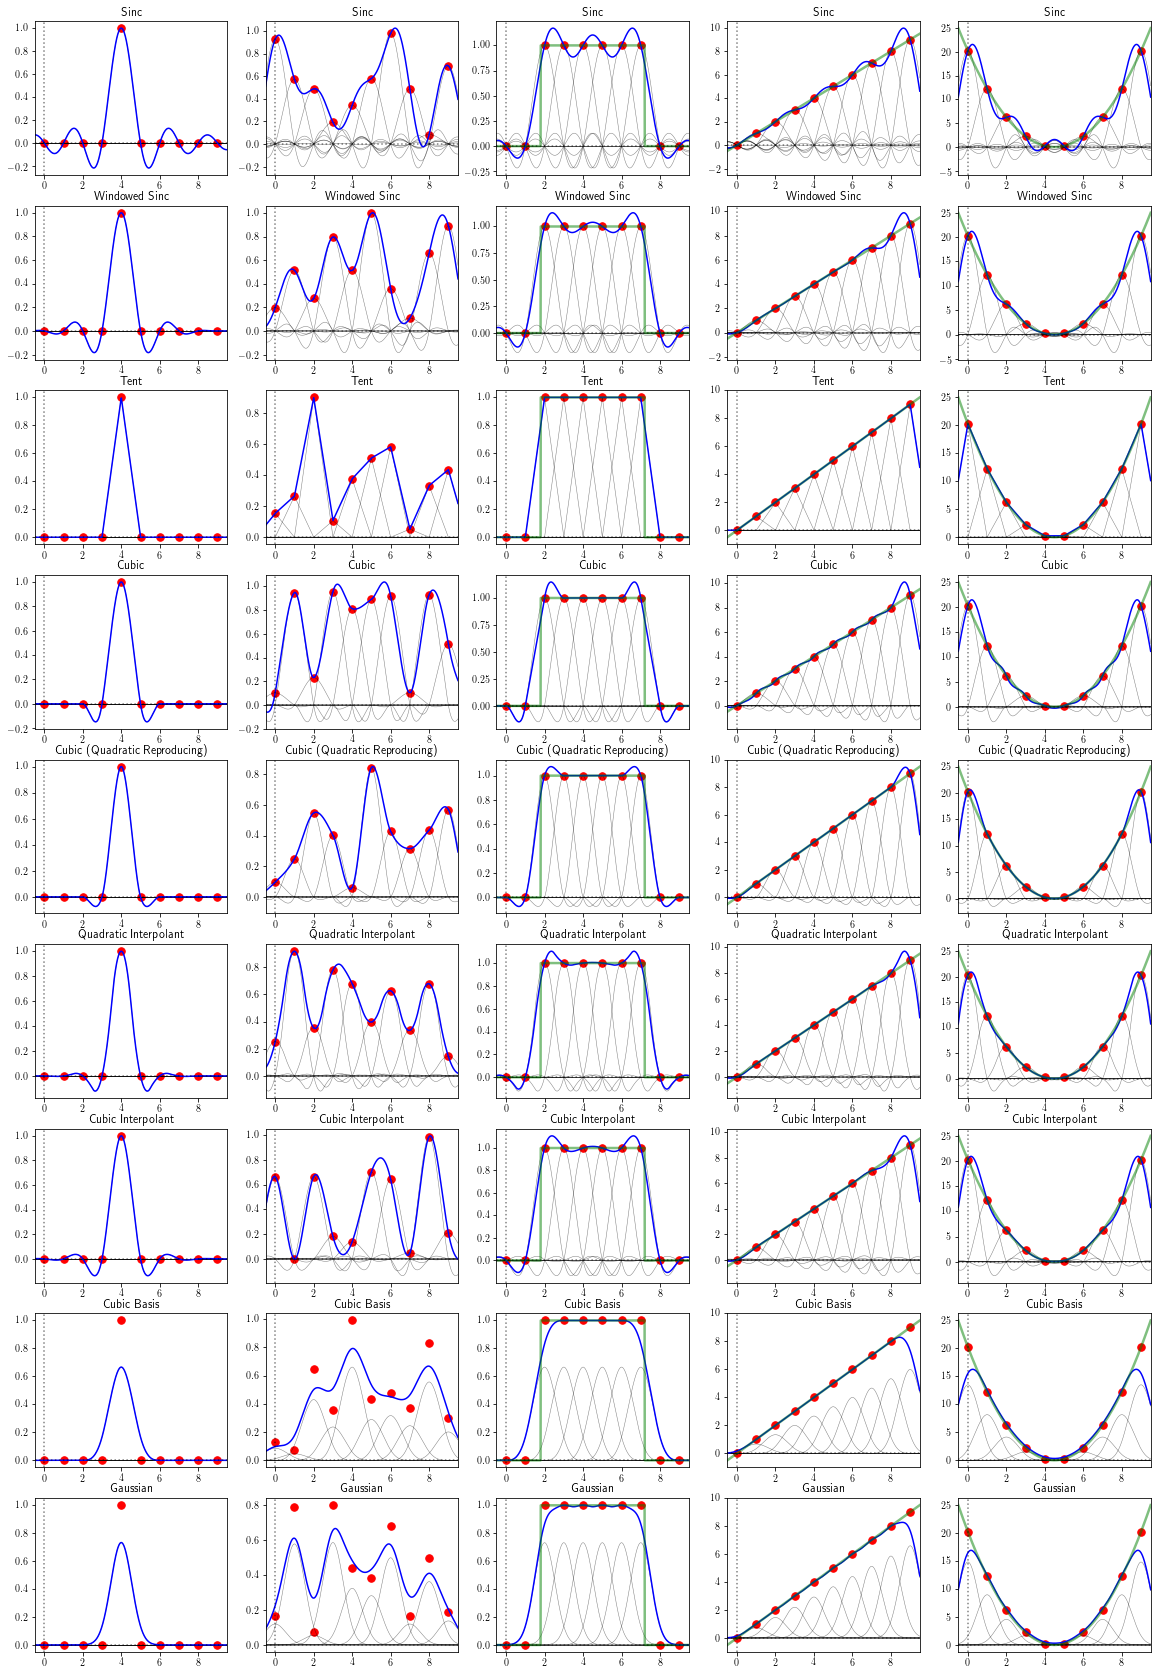

In [15]:
nSamples = 9
t = np.linspace(-0.5,nSamples + 0.5,1000)
ns = np.arange(0,nSamples+1)

figure = plt.figure()
figure.set_size_inches(20,30)
figure.clf()

kernelTypes = ['Sinc','Windowed Sinc','Tent','Cubic','Cubic (Quadratic Reproducing)','Quadratic Interpolant','Cubic Interpolant','Cubic Basis','Gaussian']
#kernelTypes = ['Cubic Basis']
nKernels = len(kernelTypes)
nSignals = 5 # There are 6, but the cubic isn't very informative
for cKernel,kernelType in enumerate(kernelTypes):
    for cSignal in range(nSignals):
        if cSignal==0:
            x = np.zeros(nSamples+1)
            x[int(nSamples/2)] = 1
            xc = np.ones_like(t)*np.nan # Don't plot    
        elif cSignal==1:
            x = np.random.rand(nSamples+1)
            xc = np.ones_like(t)*np.nan # Don't plot
        elif cSignal==2:
            x  = (ns>=nSamples*0.2)*(ns<=nSamples*0.8)
            xc = (t>=nSamples*0.2)*(t<=nSamples*0.8)           
        elif cSignal==3:
            x  = np.arange(nSamples+1)
            xc = t
        elif cSignal==4:
            x = (np.arange(nSamples+1) - nSamples/2)**2
            xc = (t-nSamples/2)**2
        elif cSignal==5:
            x = (np.arange(nSamples+1) - nSamples/2)**3        
            xc = (t-nSamples/2)**3

        axes = figure.add_subplot(nKernels,nSignals,cKernel*nSignals+cSignal+1)

        axes.plot(ns,x,color='r',linestyle='none',marker='.',markersize=15)
        xi = np.zeros_like(t) # Interpolated
        for n in ns:
           axes.plot(t,x[n]*Kernel(t,n,kernelType=kernelType),color='k',alpha=0.5,linewidth=0.5) 
           xi = xi + x[n]*Kernel(t,n,kernelType=kernelType)
        axes.plot(t,xi,color='b',linewidth=1.5)
        axes.plot(t,xc,color='g',linewidth=2.5,alpha=0.5)
        axes.axhline(0,color='k',linestyle=':',alpha=0.5)
        axes.axvline(0,color='k',linestyle=':',alpha=0.5)
        axes.set_xlim([t[0],t[-1]])
        axes.set_title(kernelType)
    
plt.show()

# We run in to problems because the green function has a sharp edge, and the band-limited interpolation
# depends on the band-limited. With a sharp edge, we have infinite frequencies, and so it's not band
# limited, so we get Gibb's oscillations.

# Windowed sinc is a little better but we still have problems
# the tent function is a lot better in flat areas.
# Cubic and quadratic interpolants still have some ringing. But they are good at
# reproducing flat areas (which is what we are most sensitive to visually)
# cubic basis is pretty good and gaussian is pretty good, but tent is better.

## Discrete vs Continuous

* In most instances we will upsample by a factor of 2
* In those cases, the kernels could be specified at just discrete values (midpoints between red dots above)
* However, we'll see shortly that there are other times in which we'll need a way to interpolate an image
* This makes the ability to do continuous interpolate valuable
* An image is normally an array of pixels that can be thought of as a matrix (gray scale) or small set of matrices (color)
* Interpolation enables us to think of the image as a surface and calculte what the value is any point on that surface

### Ringing
* We have to look closely at each of these to determine which ones can represent a flat planar surface
* Not obvious from the plots above
* If we zoom in on the flat pulse, we can see which ones continue to ring or oscillate between samples
* Our eyes are very sensitive to these subtle fluctuations in intensity in images
* Generally, best to pick kernels that can reproduce flat regions perfect, after edge effects are done
* Which ones do you think will produce these oscillations?
* The results are surprising - at least to me

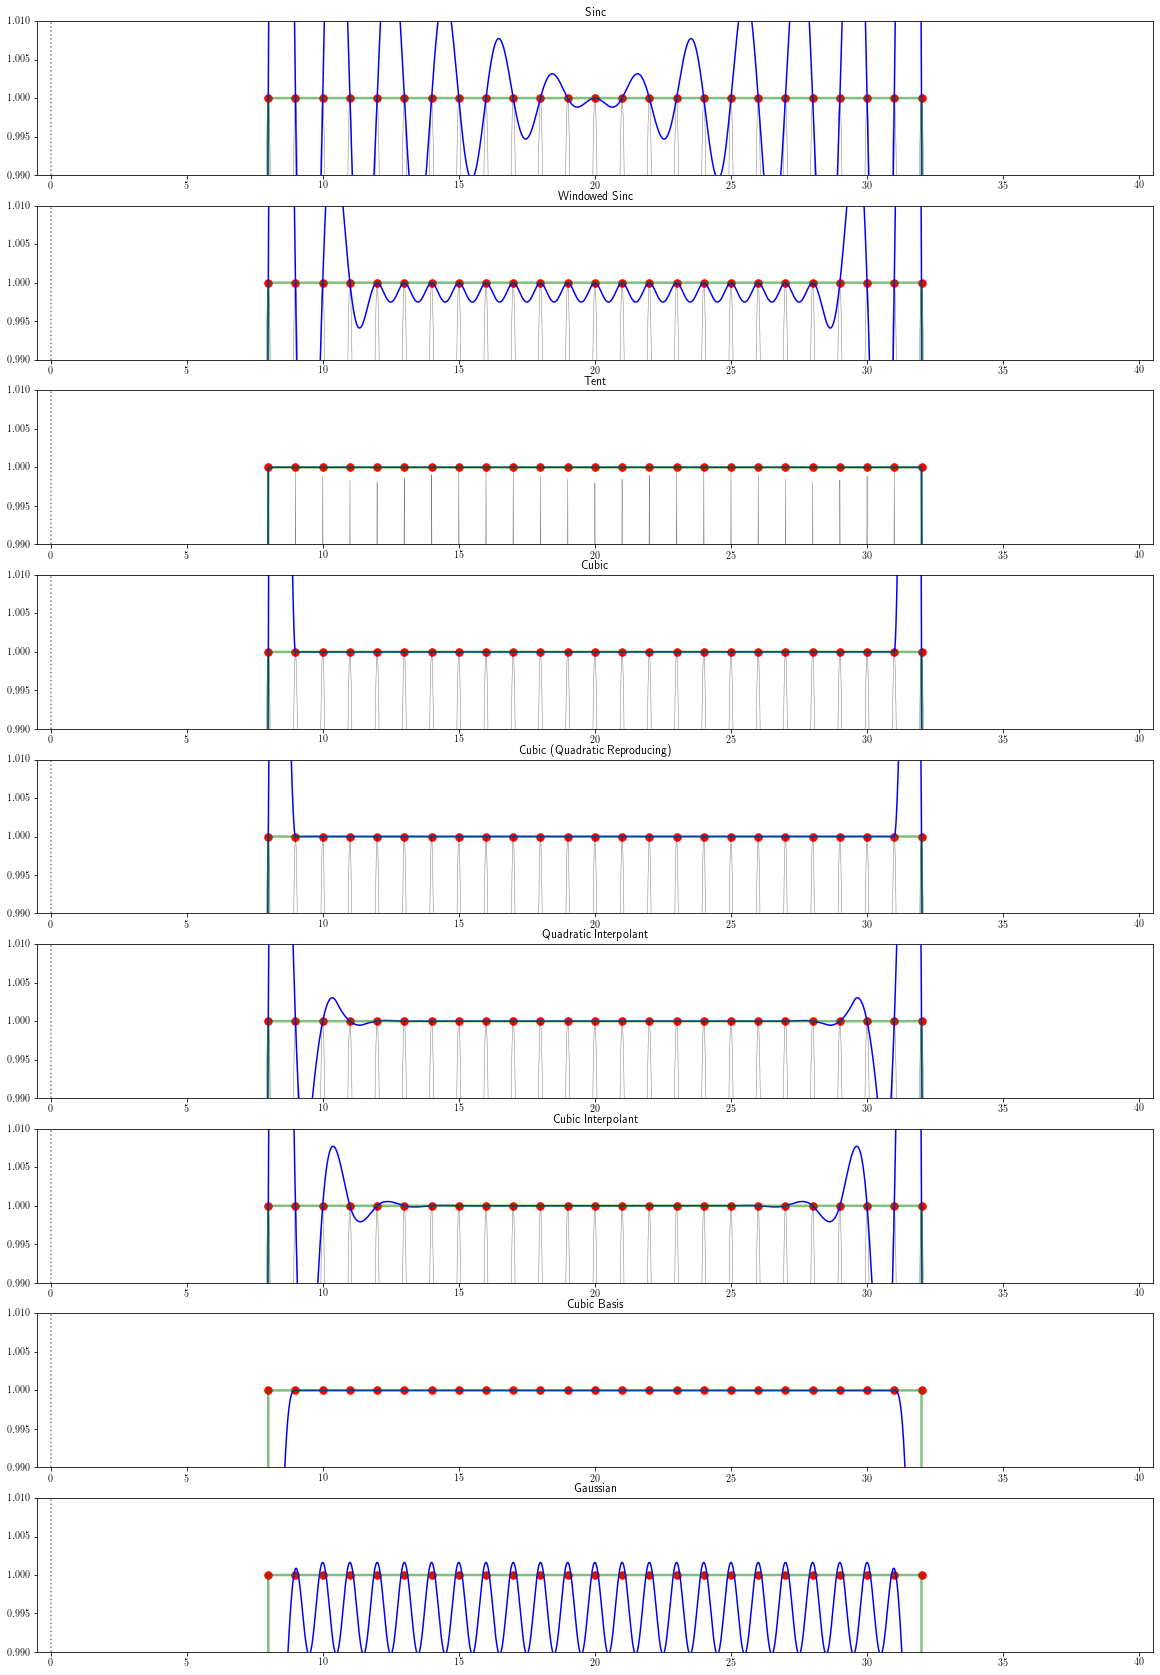

In [16]:
nSamples = 40
offset = 0.01

t = np.linspace(-0.5,nSamples + 0.5,10000)
ns = np.arange(0,nSamples+1)

figure = plt.figure()
figure.set_size_inches(20,30)
figure.clf()

kernelTypes = ['Sinc','Windowed Sinc','Tent','Cubic','Cubic (Quadratic Reproducing)','Quadratic Interpolant','Cubic Interpolant','Cubic Basis','Gaussian']
#kernelTypes = ['Cubic Basis']
nKernels = len(kernelTypes)
for cKernel,kernelType in enumerate(kernelTypes):
    x  = (ns>=nSamples*0.2)*(ns<=nSamples*0.8)
    xc = (t>=nSamples*0.2)*(t<=nSamples*0.8)           

    axes = figure.add_subplot(nKernels,1,cKernel+1)

    axes.plot(ns,x,color='r',linestyle='none',marker='.',markersize=15)
    xi = np.zeros_like(t) # Interpolated
    for n in ns:
       axes.plot(t,x[n]*Kernel(t,n,kernelType=kernelType),color='k',alpha=0.5,linewidth=0.5) 
       xi = xi + x[n]*Kernel(t,n,kernelType=kernelType)
    axes.plot(t,xi,color='b',linewidth=1.5)
    axes.plot(t,xc,color='g',linewidth=2.5,alpha=0.5)
    axes.axhline(0,color='k',linestyle=':',alpha=0.5)
    axes.axvline(0,color='k',linestyle=':',alpha=0.5)
    axes.set_xlim([t[0],t[-1]])
    axes.set_ylim([1-offset,1+offset])
    axes.set_title(kernelType)

plt.show()

### Types of Kernels

* Kernels may either approximate or interpolate
    * Approximating kernels do not go exactly through the specified points
    * Interpolating kernels do go exactly through the specified points
* In practice, sinc is not a good choice
    * It decays slowly (inversely with the time of the sample)
    * It has infinite extent
    * The ringing is undesirable
* It is possible to use a windowed sinc instead

$w(t) \mathrm{sinc}(t)$

* But then, of course, there are many possible windows to choose from
    * Classic tradeoff of main lobe width vs side lobe height

### Upsampling

* Often we will be upsampling by an integer amount
* Most often, this will be by a factor of 2
* There is nothing to prevent us from resampling at any points we like (as illustrated above)
* But things get a bit easier when you upsample by an integer amount
* And ultimately our resulting upsampled image has to have an integer number of evenly-spaced pixels

### Image Upsampling
* Image upsampling is just one dimension upsampling applied to rows and columns __separately__
* We start by creating an image that is the appropriate size of the new image
* Everything is initialized with values of 0
* We then fill in every $k$th row with the values of the original image, where k is the upsampling rate.

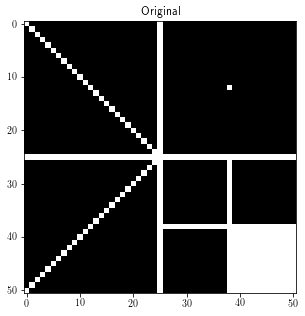

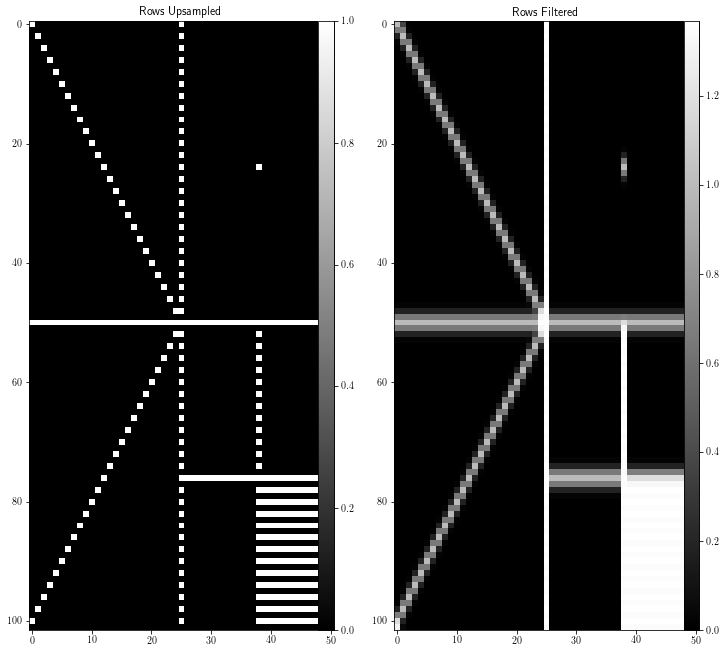

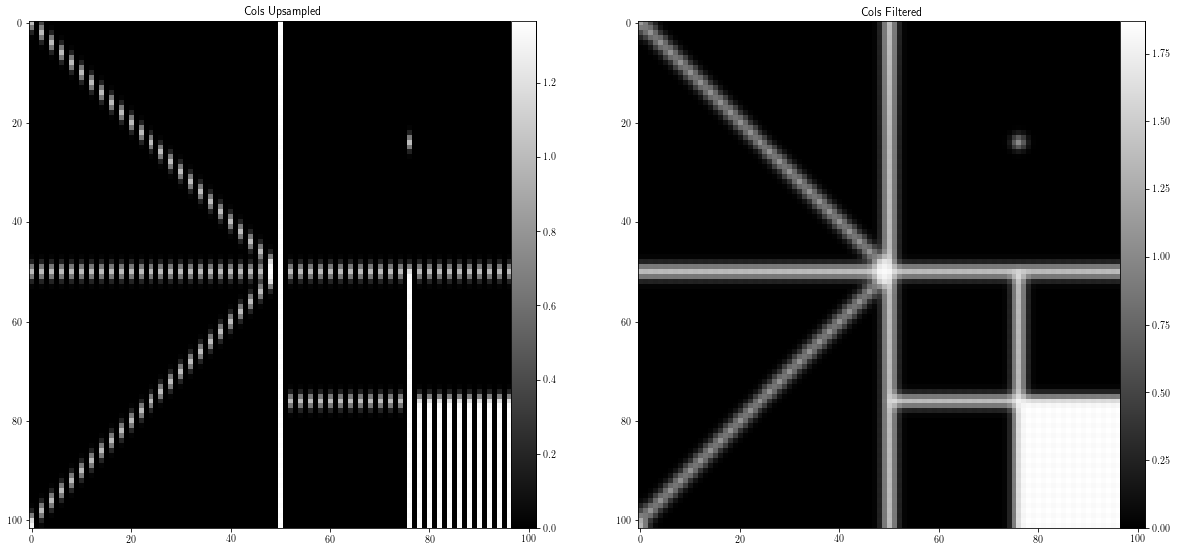

In [17]:
upsample = 2
#order = upsample*8+1
order = upsample*4+1

n  = np.arange(-(order-1)/2,(order-1)/2+1)/upsample
#kv = Kernel(n,0,'Cubic (Quadratic Reproducing)')
#kv = Kernel(n,0,'Tent')
kv = Kernel(n,0,'Gaussian')
#kv = Kernel(n,0,'Sinc')
#kv = Kernel(n,0,'Sinc')
kv = kv.reshape(-1, 1)
kh = np.transpose(kv)

#image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
#image = image[20:50,20:50]
#image = image[150:220,150:220]
image = GetTestImage(nPixelsPerSide=51)

imageRowUp = np.zeros((image.shape[0]*upsample,image.shape[1]),dtype='float')
imageRowUp[::upsample] = image
# figure = plt.figure(0)
# plt.imshow(imageRowUp)

imageRowFiltered = cv.filter2D(imageRowUp,-1,kv) 
# figure = plt.figure(1)
# plt.imshow(imageRowFiltered)


imageColUp = np.zeros((imageRowFiltered.shape[0],image.shape[1]*upsample),dtype='float')
imageColUp[:,::upsample] = imageRowFiltered
# figure = plt.figure(2)
# plt.imshow(imageColUp)

imageColFiltered = cv.filter2D(imageColUp,-1,kh) 
# figure = plt.figure(3)
# plt.imshow(imageColFiltered)

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,5)

axes = figure.add_subplot(111)
axes.imshow(image,cmap='gray')
axes.set_title('Original')

plt.show()

figure = plt.figure()
figure.clf()
figure.set_size_inches(12,15)

axes = figure.add_subplot(121)
axes.imshow(imageRowUp,cmap='gray')
axes.set_title('Rows Upsampled')
AddColorbar(axes)

axes = figure.add_subplot(122)
axes.imshow(imageRowFiltered,cmap='gray')
axes.set_title('Rows Filtered')
AddColorbar(axes)

plt.show()

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,10)

axes = figure.add_subplot(121)
axes.imshow(imageColUp,cmap='gray')
axes.set_title('Cols Upsampled')
AddColorbar(axes)

axes = figure.add_subplot(122)
axes.imshow(imageColFiltered,cmap='gray')
axes.set_title('Cols Filtered')
AddColorbar(axes)

plt.show()

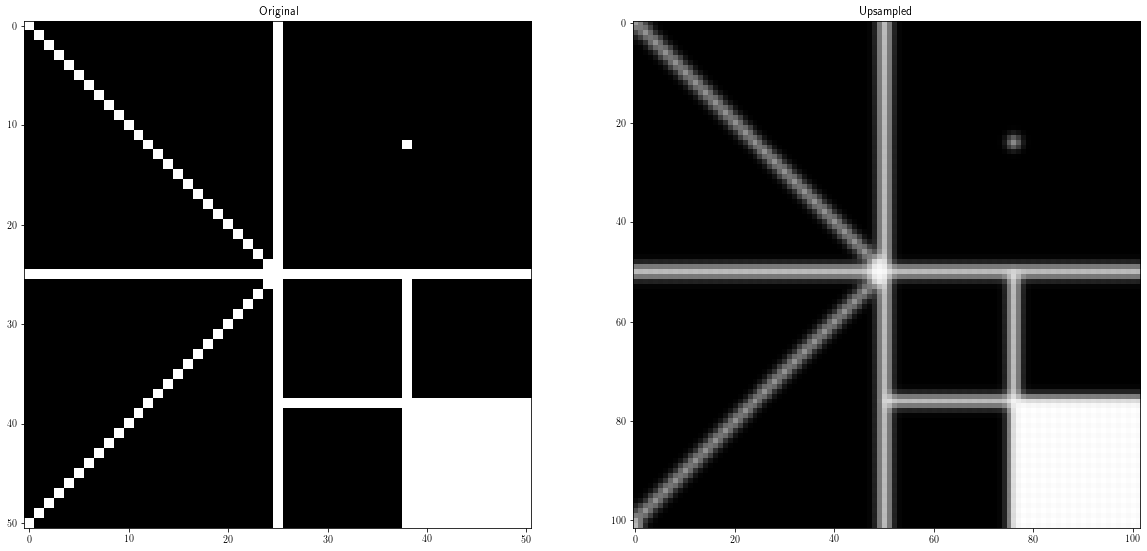

In [18]:
figure = plt.figure()
figure.clf()
figure.set_size_inches(20,10)

axes = figure.add_subplot(121)
axes.imshow(image,cmap='gray')
axes.set_title('Original')

axes = figure.add_subplot(122)
axes.imshow(imageColFiltered,cmap='gray')
axes.set_title('Upsampled')

plt.show()

### OpenCV pyrUp

* OpenCV uses a function called pyrUp (pyramid upsample)
* How well does it perform
* What kernel does it use?

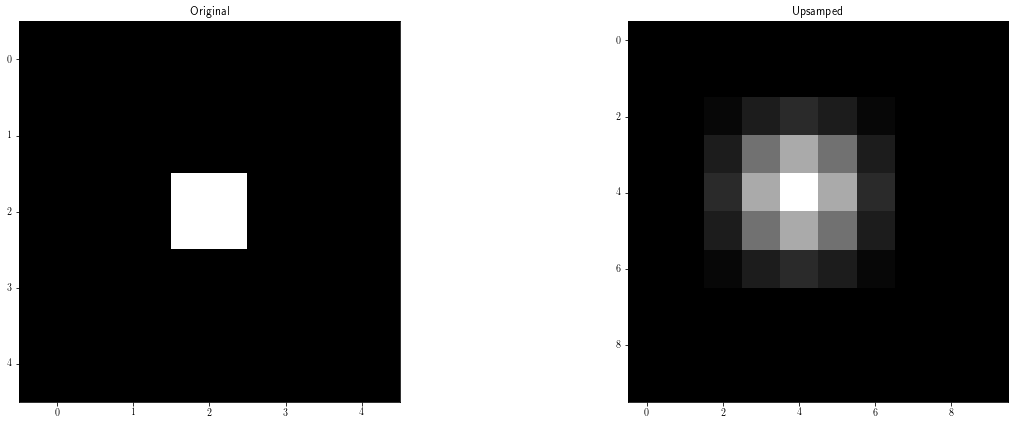

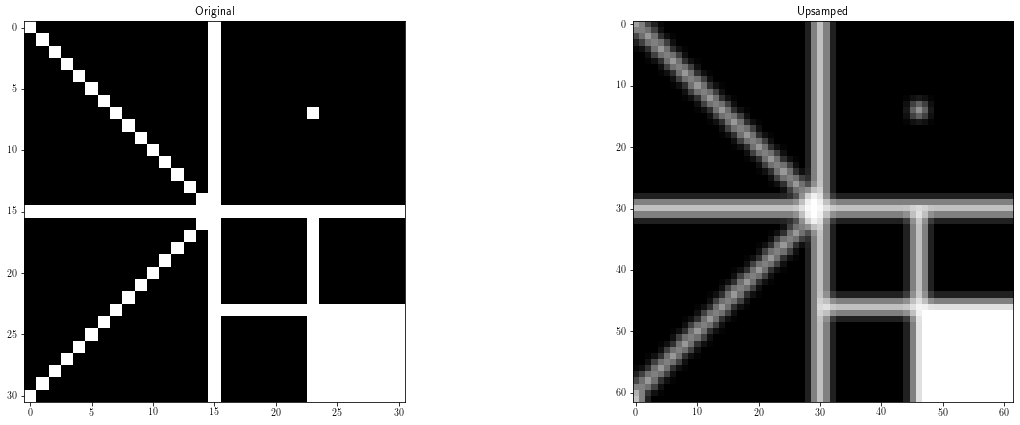

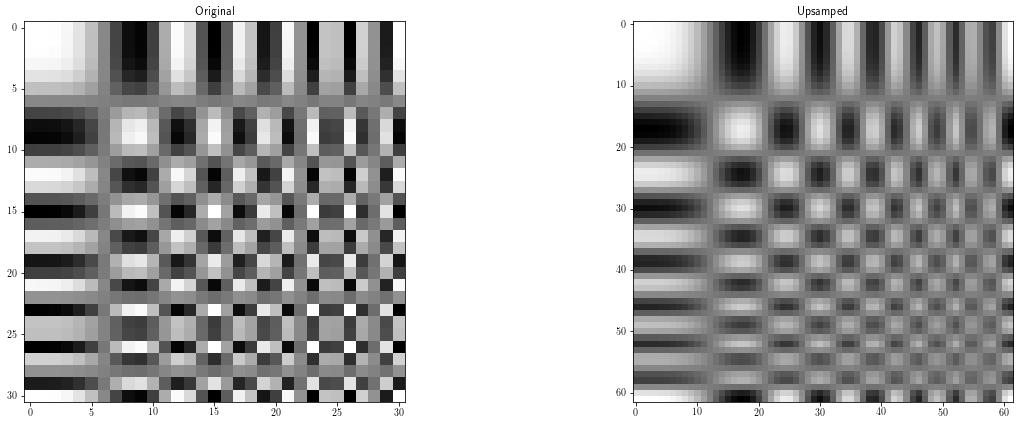

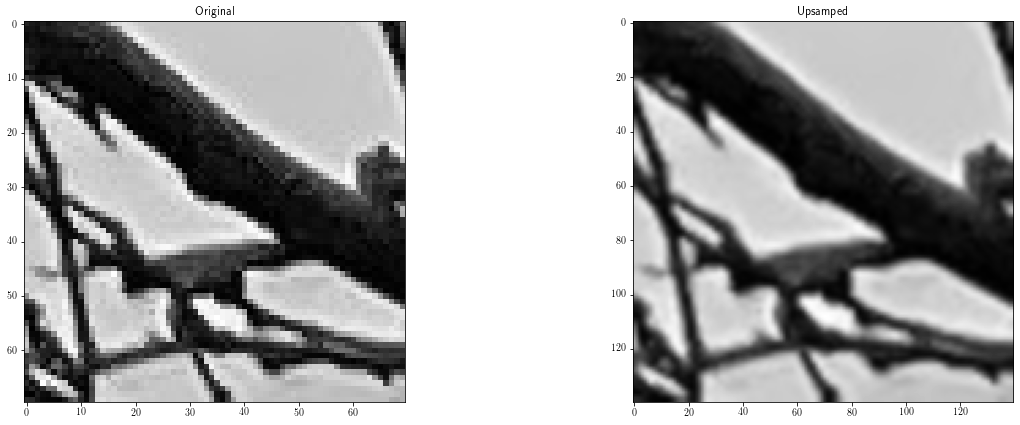

In [19]:
upsampleRate = 2

for cImage in range(4):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=5)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]

    upsampled = cv.pyrUp(image,dstsize=(int(upsampleRate*image.shape[1]),int(upsampleRate*image.shape[0])))
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,2,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,2,2)
    axes.imshow(upsampled,cmap='gray')
    axes.set_title('Upsamped')

    plt.show()

#### PyrUp
* Uses a 5 x 5 Kernel
* Roughly Gaussian
* They describe it as Gaussian in the documentation
    * However, it clearly isn't Gaussian 
        * No ripple
    * Seems to be actually a bit better than Gaussian (less ripple in constant regions)
    * it's actually a binomal kernel k = [1 4 6 4 1]
    * intersting way to approximate a gaussian with finite duration.
* Non-negative
* Preserves constant regions with minimal ripple
* Visually looks good (subjectively)
* Can only upsample by 2



Maximum absolute error (MAE): 0.1667


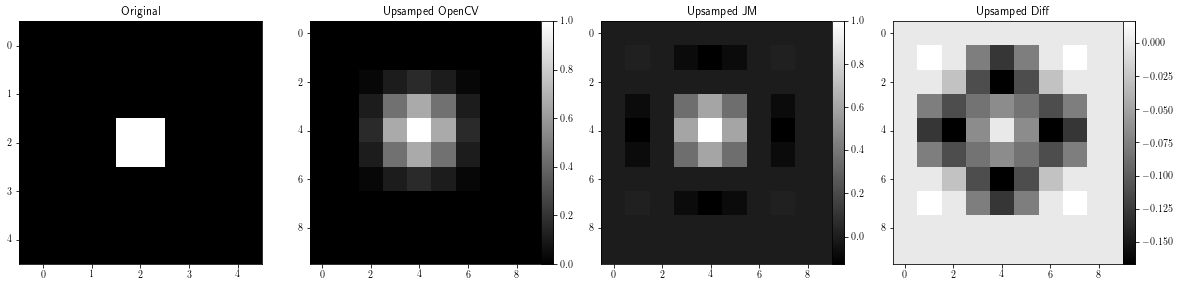

Maximum absolute error (MAE): 0.4049


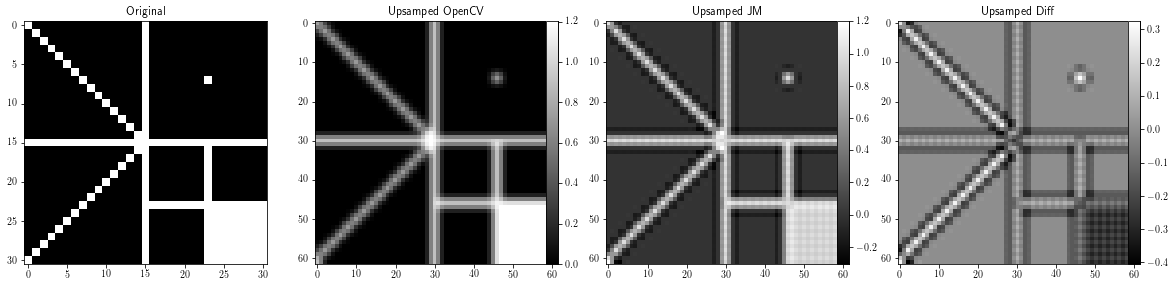

Maximum absolute error (MAE): 1.0623


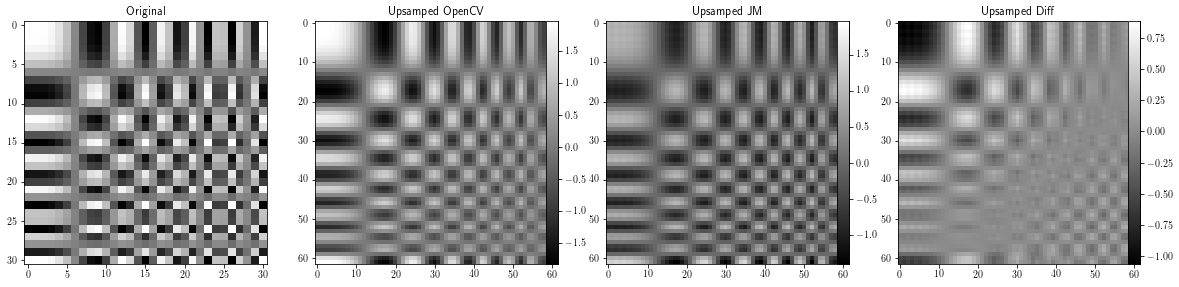

Maximum absolute error (MAE): 52.1355


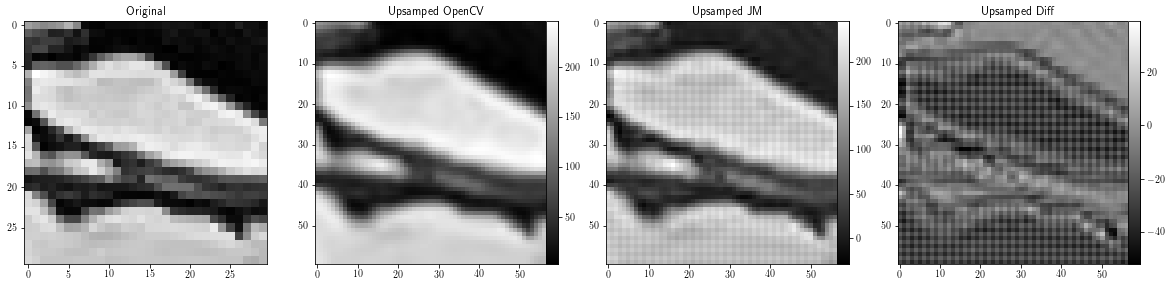

In [20]:
upsampleRate = 2
kernelName = 'Gaussian'
kernelName = 'Windowed Sinc'
kernelName = 'Cubic'
kernelName = 'Cubic Interpolant'
#kernelName = 'Cubic Basis'
#kernelName = 'Quadratic Interpolant'

for cImage in range(4):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=5)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[190:220,190:220].astype('float')

    upsampledCV = cv.pyrUp(image,dstsize=(int(upsampleRate*image.shape[1]),int(upsampleRate*image.shape[0])))        
    #upsampledJM = UpsampleImage(image,upsample=2,kernelName=kernelName,parameter=0.5425)
    upsampledJM = UpsampleImage(image,upsample=2,kernelName=kernelName)
    
    upsampledCV *= upsampledJM.max()/upsampledCV.max()

    difference = upsampledJM-upsampledCV
    
    print('Maximum absolute error (MAE): %5.4f' % np.abs(difference).max())
    
    figure = plt.figure()
    figure.set_size_inches(20,10)
    figure.clf()
    
    axes = figure.add_subplot(1,4,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,4,2)
    axes.imshow(upsampledCV,cmap='gray')
    axes.set_title('Upsamped OpenCV')
    AddColorbar(axes)
    
    axes = figure.add_subplot(1,4,3)
    axes.imshow(upsampledJM,cmap='gray')
    axes.set_title('Upsamped JM')
    AddColorbar(axes)   
    
    axes = figure.add_subplot(1,4,4)
    axes.imshow(difference,cmap='gray')
    axes.set_title('Upsamped Diff')
    AddColorbar(axes) 

    plt.show()

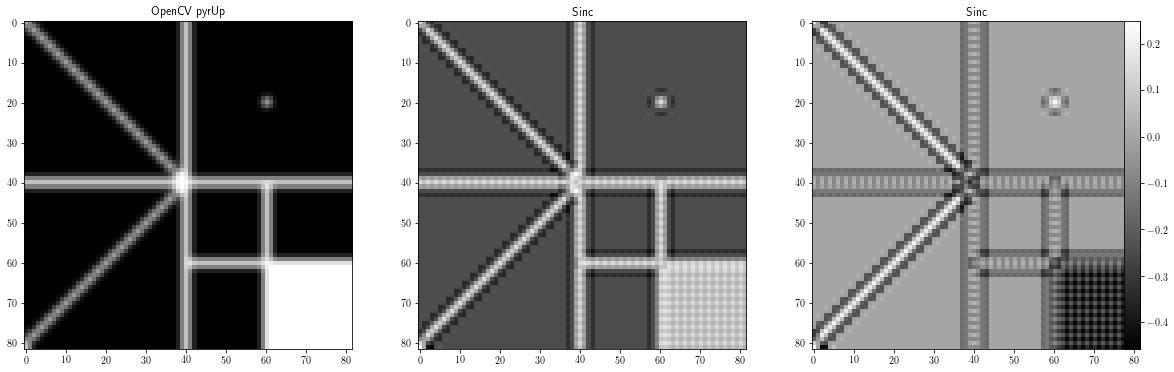

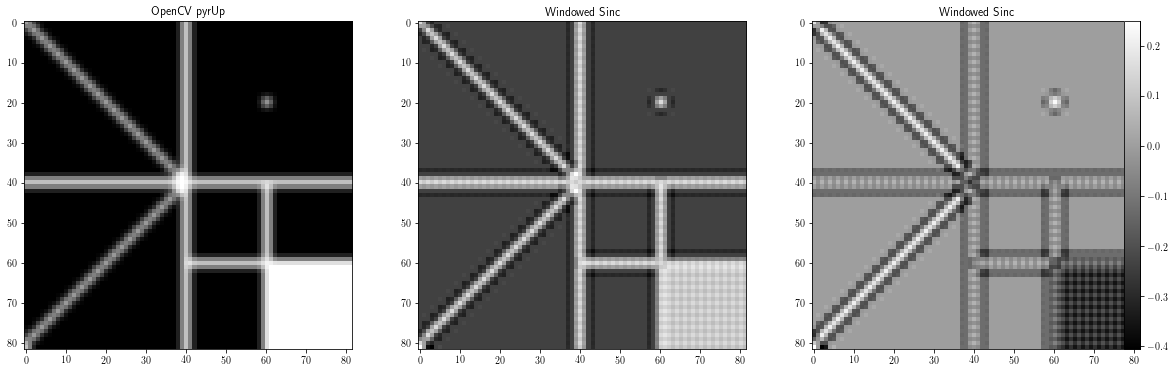

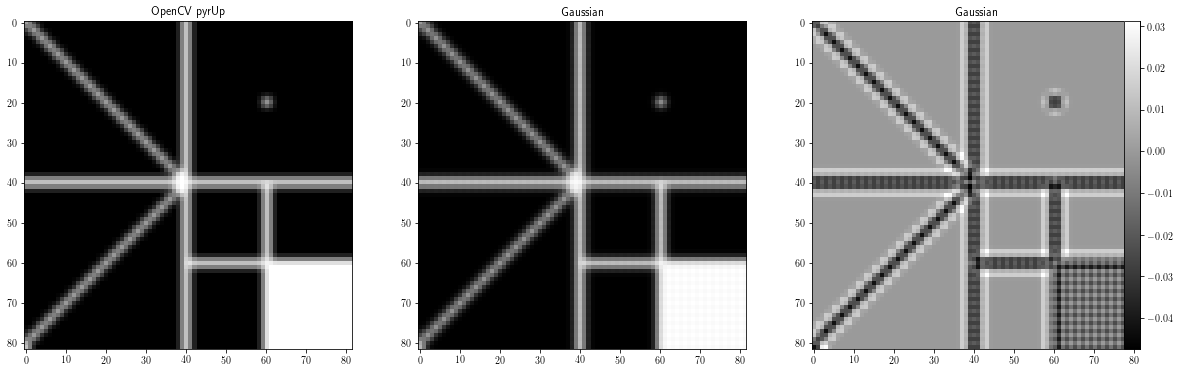

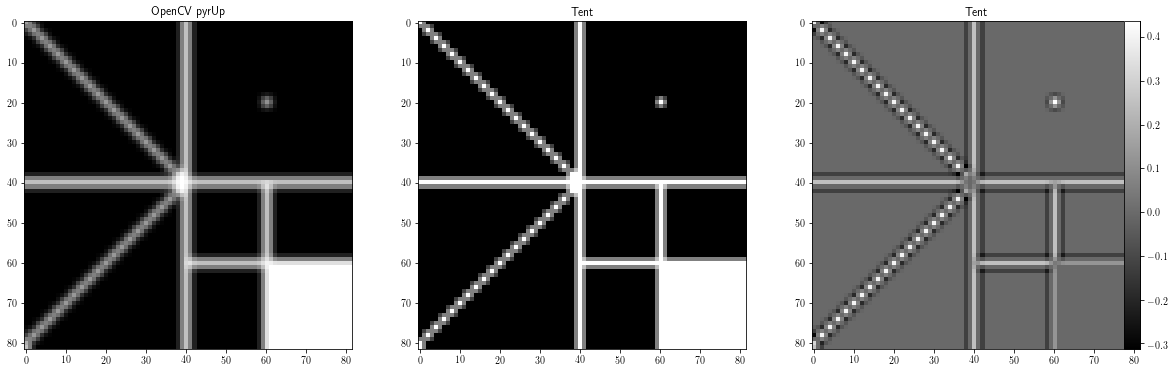

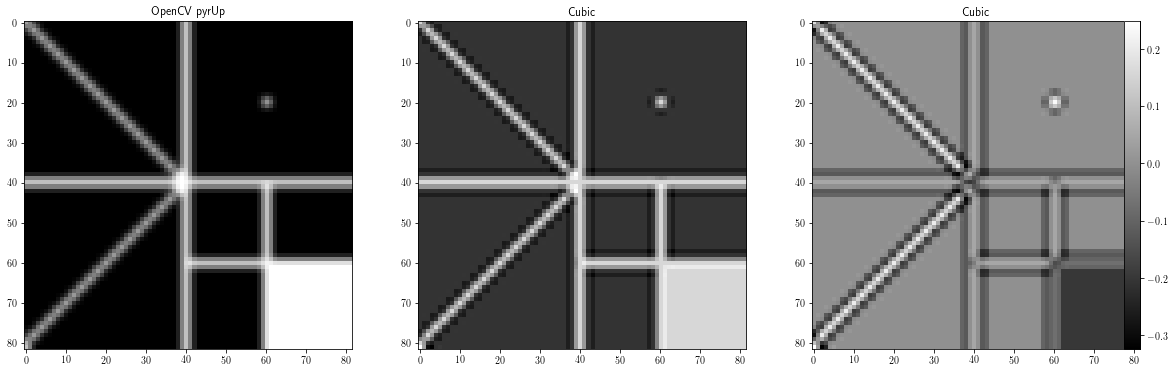

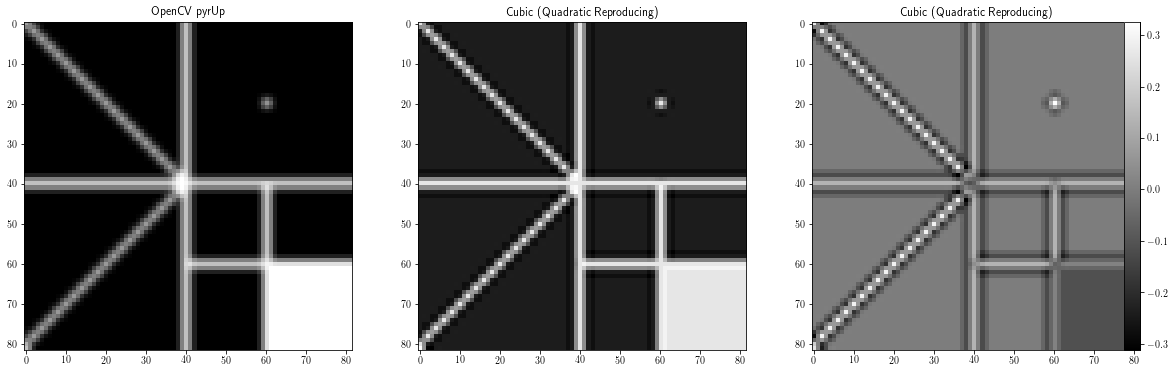

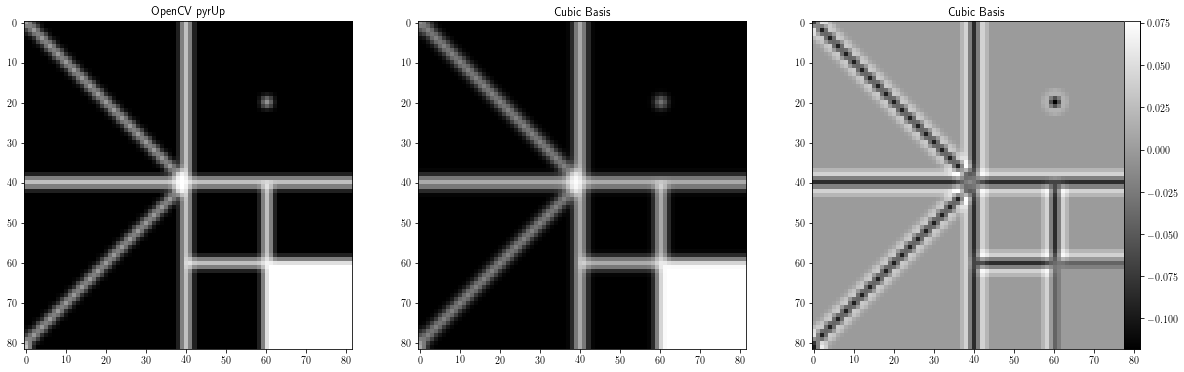

In [21]:
kernelNames = ['Sinc','Windowed Sinc','Gaussian','Tent','Cubic','Cubic (Quadratic Reproducing)','Cubic Basis']
#kernelNames = ['Gaussian'] # DEBUG
nKernels = len(kernelTypes)

#image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
#image = image[150:220,150:220]
image = GetTestImage(nPixelsPerSide=41)

upsampleRate = 2
        
openCvUp = cv.pyrUp(image,dstsize=(upsampleRate*image.shape[1],upsampleRate*image.shape[0]))   
openCvUp /= openCvUp.max()

for cKernel,kernelName in enumerate(kernelNames):
    upsampled = UpsampleImage(image,upsample=2,kernelName=kernelName)
    upsampled /= upsampled.max()
    
    figure = plt.figure()
    figure.set_size_inches(20,10)
    figure.clf()
    
    #axes = figure.add_subplot(1,3,1)
    #axes.imshow(image,cmap='gray')
    #axes.set_title('Original')
    
    axes = figure.add_subplot(1,3,1)
    axes.imshow(openCvUp,cmap='gray')
    axes.set_title('OpenCV pyrUp')

    axes = figure.add_subplot(1,3,2)
    axes.imshow(upsampled,cmap='gray')
    axes.set_title(kernelName)
    
    axes = figure.add_subplot(1,3,3)
    axes.imshow(upsampled-openCvUp,cmap='gray')
    axes.set_title(kernelName)
    AddColorbar(axes)

    plt.show()

## Downsampling
* We know that if we just sample the image we'll have aliasing

### Aliasing
* Aliasing is something I expect you are familiar with from when you studied sampling
* aliasing: when two signals become indistinguishable from one another. https://en.wikipedia.org/wiki/Aliasing
* we need anti-aliasing filter to prevent this
* The sampling theorem indicates that frequencies above 0.5 cycles/pixel will be indistinguishable from lower frequencies
* When this occurs, the image content at high frequencies is said to be aliased down to lower frequencies

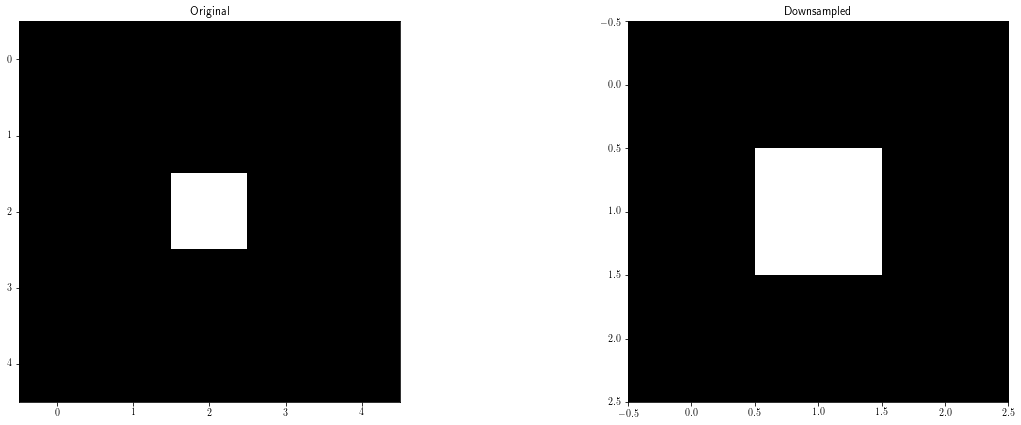

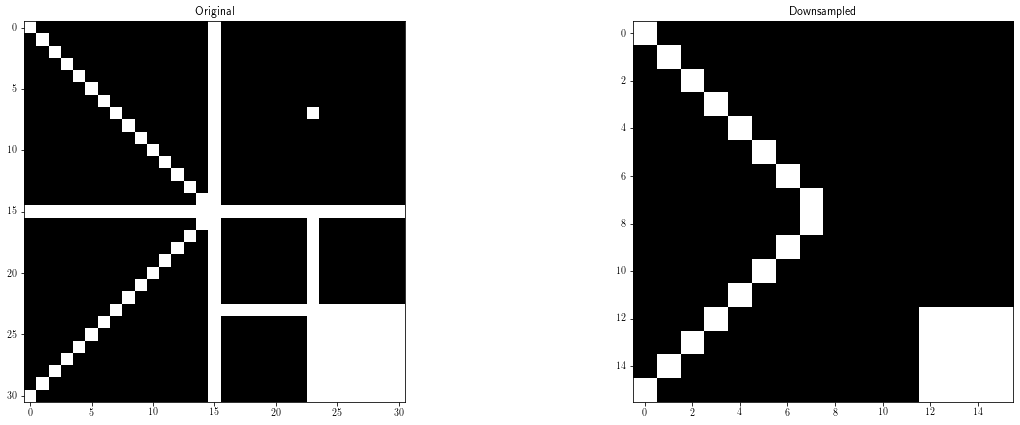

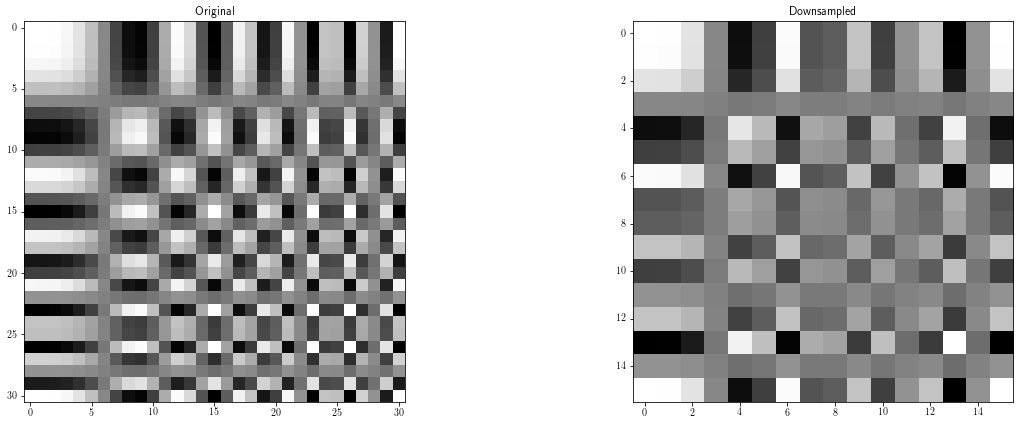

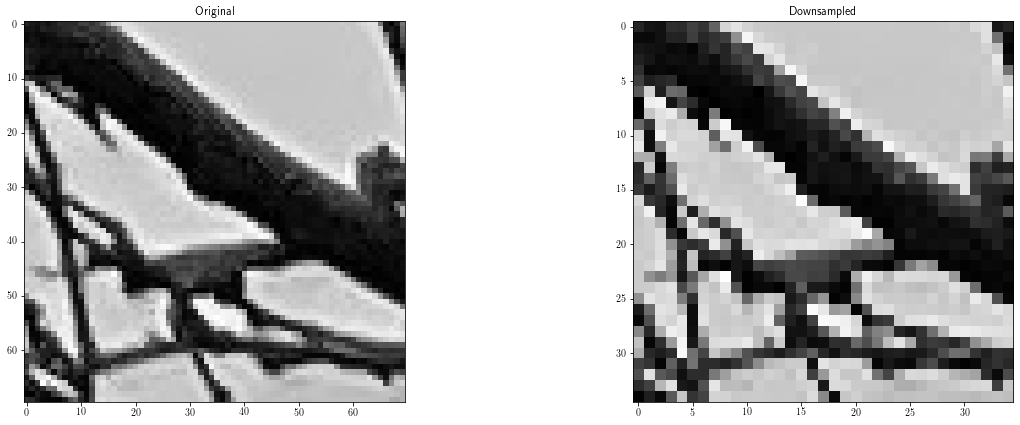

In [22]:
upsampleRate = 2

for cImage in range(4):
    if cImage==0:
      # IMPULSE
        image = GetImpulseImage(nPixelsPerSide=5)
        # We get lucky and don't just skip the bright part.
    elif cImage==1:
      # Row and Cross Pattern
        image = GetTestImage(nPixelsPerSide=31)
        # We miss the row and cross when we decimated/downsampled
        # they got thrown out so it looks different.
    elif cImage==2:
      # CHIRP IMAGE
        image = GetChirpImage(nPixelsPerSide=31)    
        # The chirp is low frequency to high frequency.
        # We see tha aliasing with lots of high frequency stuff
        # where there should be low frequency.
    else:
      # Tree image
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
        # just looks pixelated.

    downsampled = image[::2,::2]
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,2,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,2,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')

    plt.show()

### Anti-aliasing
* To prevent aliasing, we merely need to apply a lowpass filter with a cutoff frequency of _0.25 cycles/pixel_
* However, we have the usual design tradeoffs
    * We do not want the image to be shifted after filtering, so we want the filter to have an even impulse response
    * We want it to be computationally efficient, so we want FIR (finite impulse response) filters (as oppsed to IIR - infinite impulse response) that are as short as possible
    * We do not want oscillations in uniform regions, so we want to minimize oscillations (ringing) 
    * We do not want aliasing, so we want a sharp transition from the passband to the stopband

We want a filter that passes everything up to 0.25 and then drops sharply. But this might cause other issues.

In [23]:
def SymmetricKernelDTFT(kernel):
    kernelSize = len(kernel)
    omega = np.linspace(0,np.pi,500)
    ns = np.arange(-(kernelSize-1)/2,(kernelSize-1)/2+1)
    H = np.zeros_like(omega)
    
    offset = int((kernelSize-1)/2)
    for n in ns:
        H = H + kernel[int(n)+offset]*np.cos(omega*n)
    return omega,H

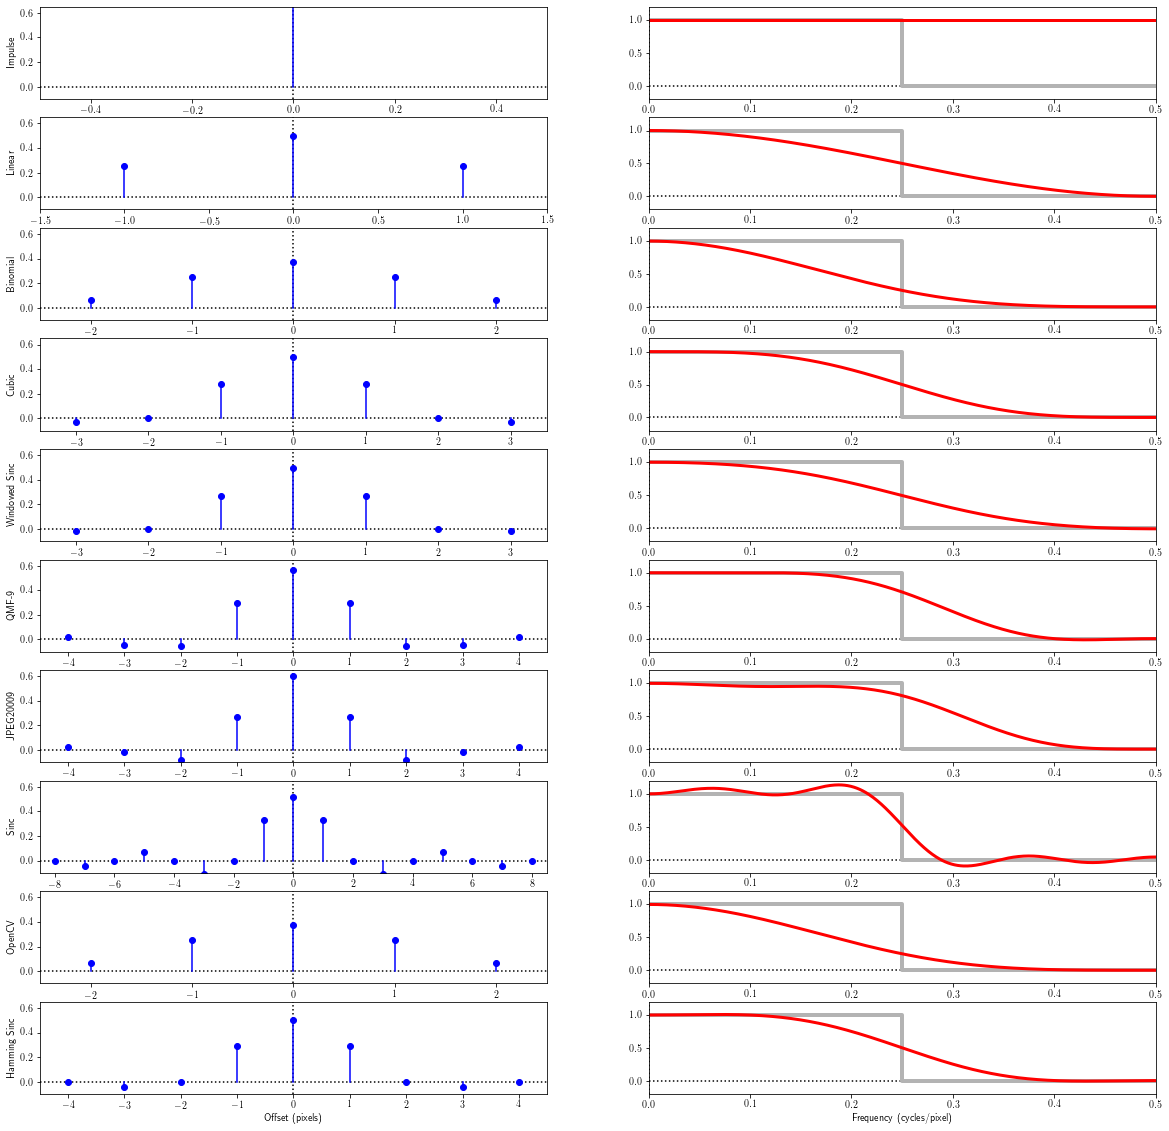

In [24]:
kernelNames = GetAntialiasingKernel()
nKernels = len(kernelNames)

# 'Impulse' - Passes all frequencies (infinite frequencies)     
# 'Linear'  - Produces blurring on positive side. When we cross 2.5 and it's not zero, this produces aliasing.
# 'Binomial' - same problems as linear
# 'Cubic'        
# 'Windowed Sinc'
# 'QMF-9'        
# 'JPEG20009' - Very little blurring, but more aliasing
# 'Sinc' - Less blurring and less aliasing but still some. Some oscillations pass some frequencies more than others?
#         needs a huge border though. 
# 'OpenCV'
# 'Hamming Sinc' - less ringing than the sinc since it has a hamming window, but a little more blurring and aliasing.
#         probably best but too much computation

figure = plt.figure()
figure.set_size_inches(20,20)
figure.clf()

for cKernel,kernelName in enumerate(kernelNames):
    h,n = GetAntialiasingKernel(kernelName=kernelName)
    omega,H = SymmetricKernelDTFT(h)    
    
    axes = figure.add_subplot(nKernels,2,cKernel*2+1)
    axes.axhline(0,color='k',linestyle=':')
    axes.axvline(0,color='k',linestyle=':')
    axes.plot(n,h,marker='.',linestyle='none',markersize=12,color='b')
    axes.plot([n,n],[np.zeros_like(h),h],color='b')
    axes.set_xlim([n[0]-0.5,n[-1]+0.5])
    axes.set_ylim([-0.1,0.65])
    axes.set_ylabel(kernelName)
    if kernelName==kernelNames[-1]:
        axes.set_xlabel('Offset (pixels)')
    
    axes = figure.add_subplot(nKernels,2,cKernel*2+2)
    axes.axhline(0,color='k',linestyle=':')
    axes.axvline(0,color='k',linestyle=':')
    axes.plot([0,0.25,0.25,0.5],[1,1,0,0],color=0.7*np.ones(3),linewidth=4.0,label='Ideal AAF')
    axes.plot(omega/(2*np.pi),H,color='r',linewidth=3.0)
    axes.set_xlim([0,0.5])
    axes.set_ylim([-0.20,1.20])
    if kernelName==kernelNames[-1]:
        axes.set_xlabel('Frequency (cycles/pixel)')
    
plt.show()

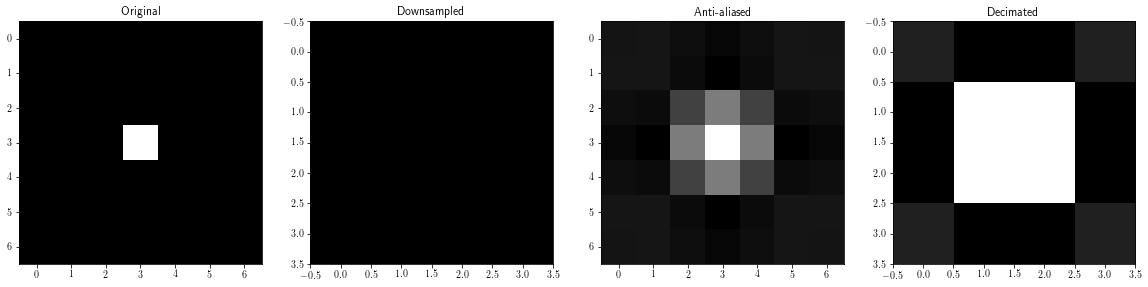

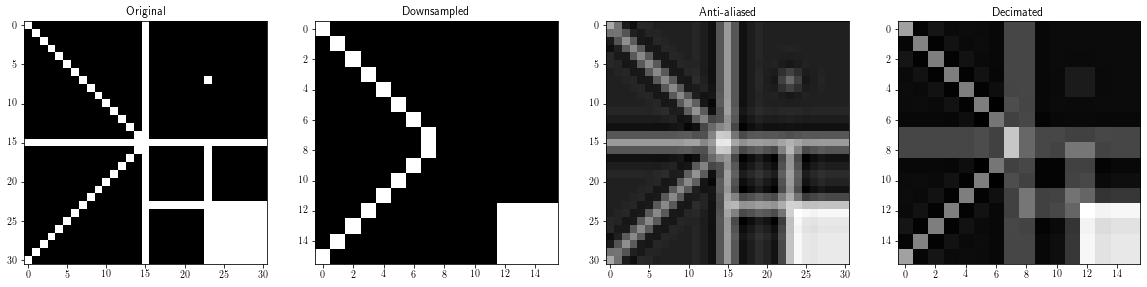

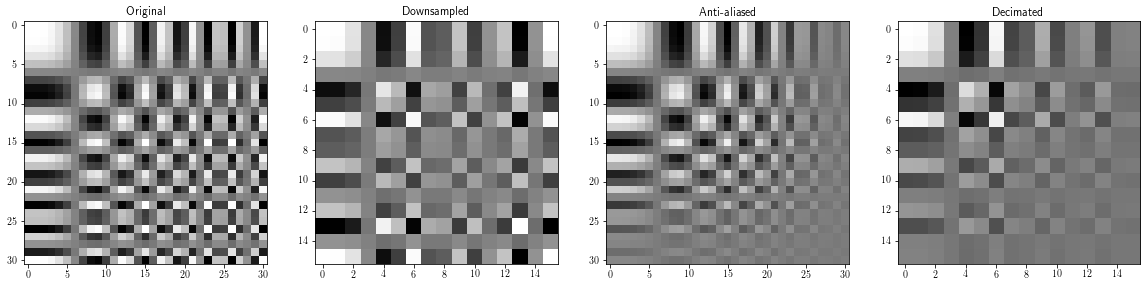

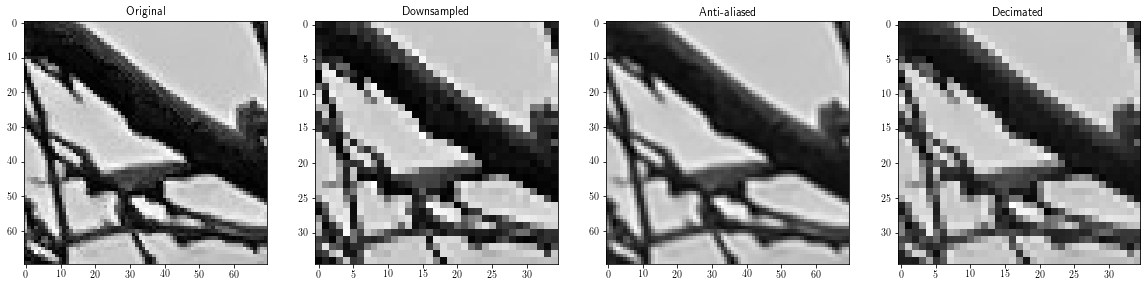

In [25]:
kernel,n = GetAntialiasingKernel('JPEG20009')
kernel = kernel.reshape(-1,1) # Convert to matrix
kernel = np.matmul(kernel,np.transpose(kernel)) # Make into a 2D Kernel

for cImage in range(4):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=7)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]

    downsampled = image[::2,::2]
    antialiased = cv.filter2D(image,cv.CV_32F,kernel)
    decimated   = antialiased[::2,::2]
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,4,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,4,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')
    
    axes = figure.add_subplot(1,4,3)
    axes.imshow(antialiased,cmap='gray')
    axes.set_title('Anti-aliased')
    
    axes = figure.add_subplot(1,4,4)
    axes.imshow(decimated,cmap='gray')
    axes.set_title('Decimated')

    plt.show()

    # Downsampled impulse - skipped the impulse part during downsampling.
    #   If we first smooth with anti-aliasing and then decimate, it's better.

    # In general this is the pattern. If we just downsample, we miss things
    # But if we anti-alias first and then decimate, it works.

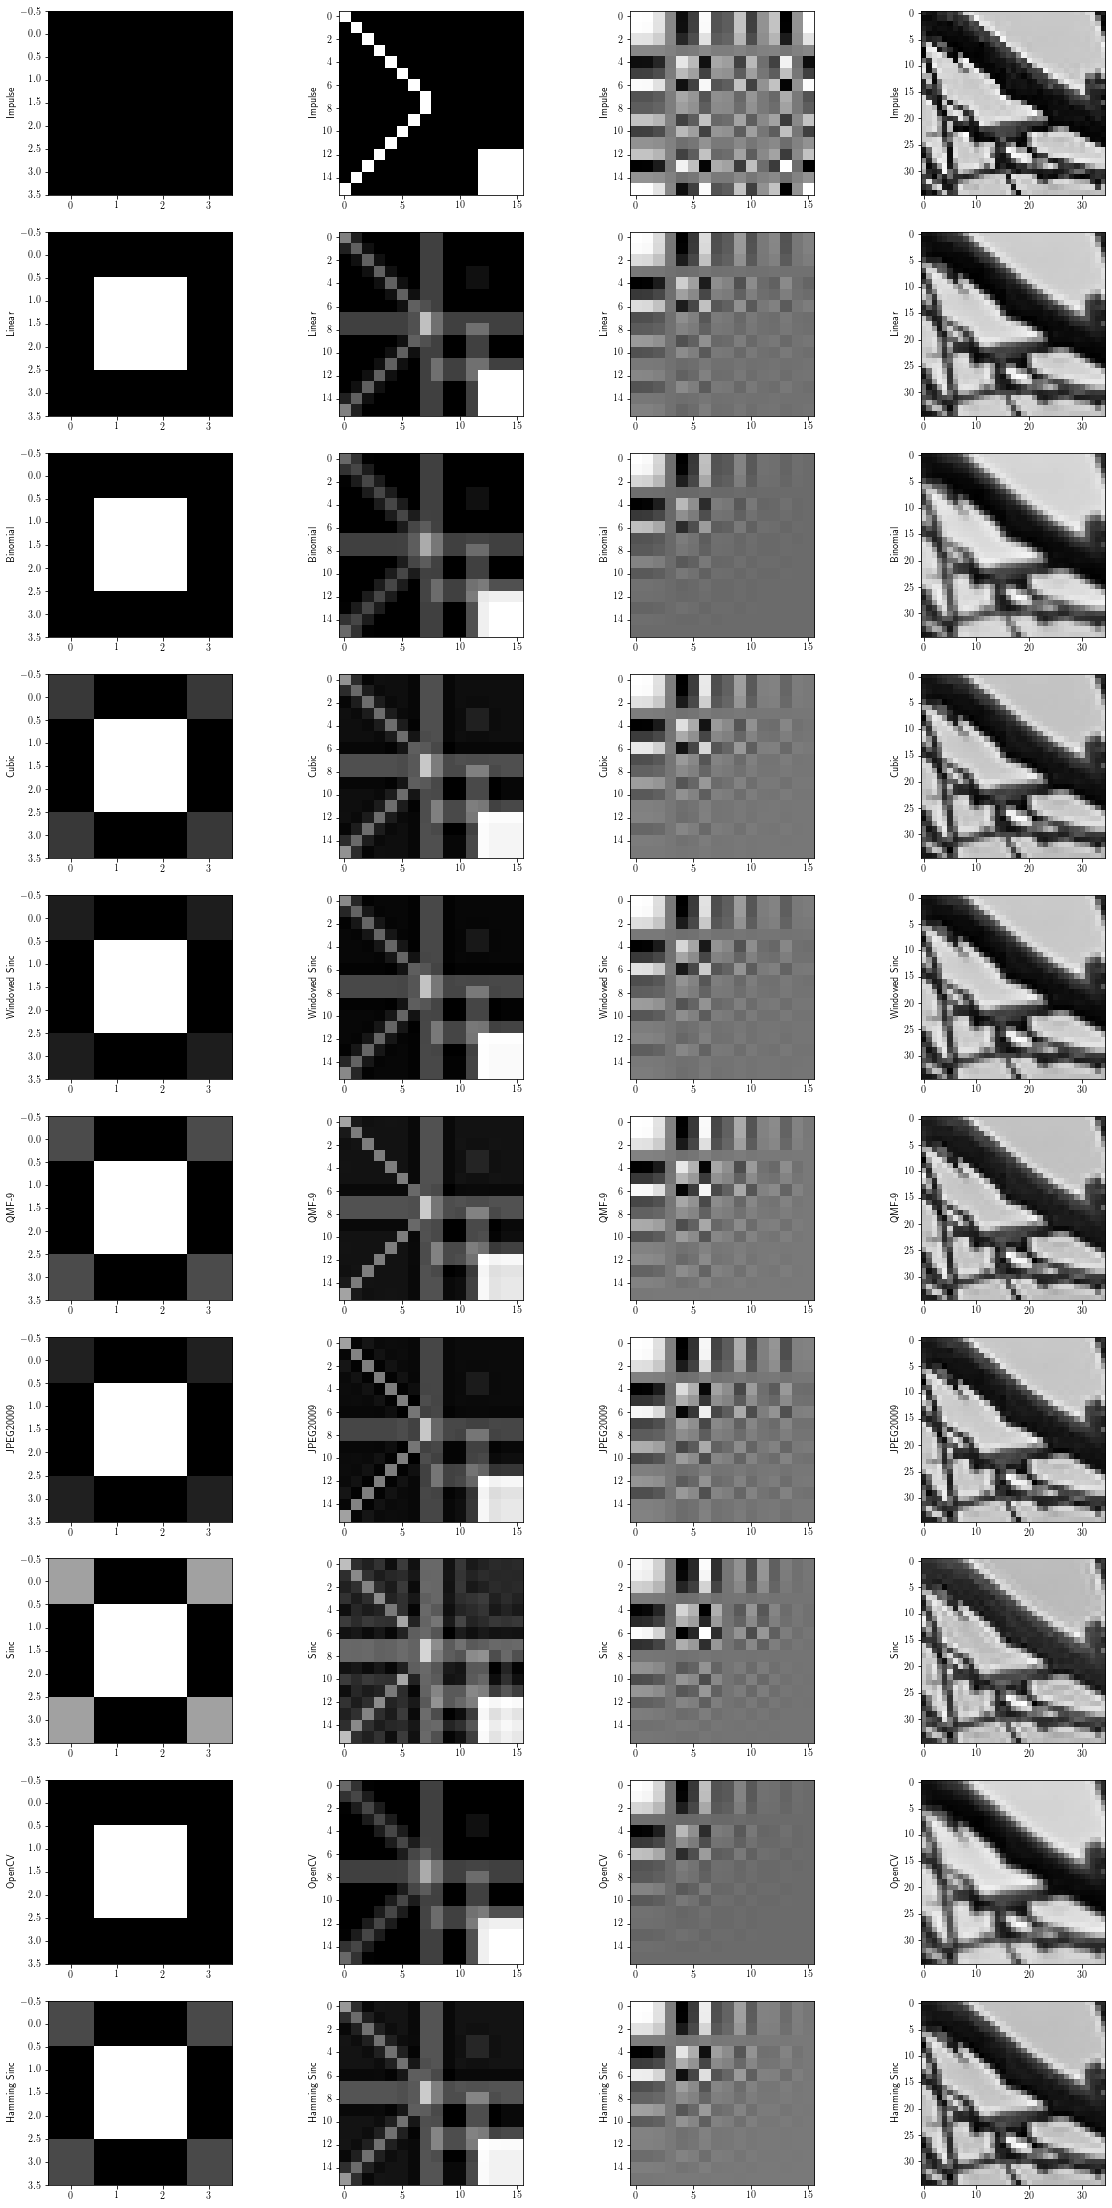

In [26]:
kernelNames = GetAntialiasingKernel()
nKernels = len(kernelNames)

nImages = 4

figure = plt.figure()
figure.set_size_inches(20,40)
figure.clf()

for cKernel,kernelName in enumerate(kernelNames):
    for cImage in range(nImages):
        if cImage==0:
            image = GetImpulseImage(nPixelsPerSide=7)
        elif cImage==1:
            image = GetTestImage(nPixelsPerSide=31)
        elif cImage==2:
            image = GetChirpImage(nPixelsPerSide=31)        
        else:
            image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
            image = image[150:220,150:220]

        image = image.astype('float')
        decimatedJM = DownsampleImage(image,kernelName=kernelName)

        axes = figure.add_subplot(nKernels,nImages,cKernel*nImages+cImage+1)
        axes.imshow(decimatedJM,cmap='gray')
        axes.set_ylabel(kernelName)

plt.show()

### OpenCV pyrDown

* OpenCV uses a function called pyrDown (pyramid downsample)
* How well does it perform
* What kernel does it use?
    * The same kernel it uses for interpolation!
* The OpenCV Documentation calls this "Gaussian"

$
\frac{1}{256}
\begin{bmatrix}
1 &  4 &  6 &  4 & 1\\
4 & 16 & 24 & 16 & 4\\
6 & 24 & 36 & 24 & 6\\
4 & 16 & 24 & 16 & 4\\
1 &  4 &  6 &  4 & 1\\
\end{bmatrix}
$

* This is based on a binomial kernel that is simply 

$\frac{1}{16} \begin{bmatrix} 1 & 4 & 6 & 4 & 1 \end{bmatrix}$

* Apparently this is called "Gaussian" because if you apply this repeatedly, it eventually becomes Gaussian
    * But so does almost everything under repeated convolution

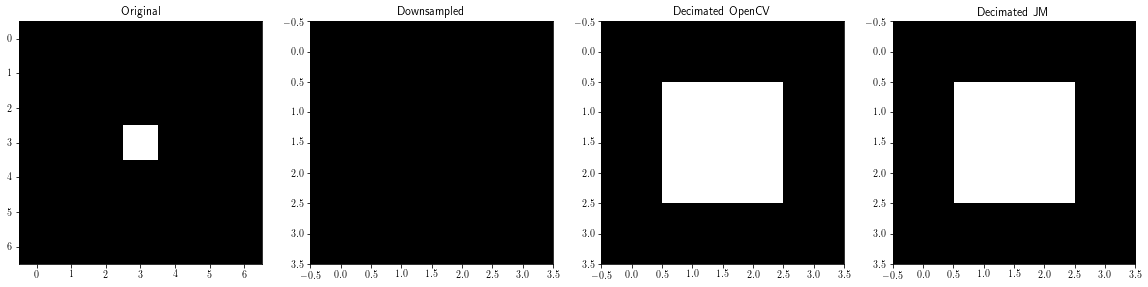

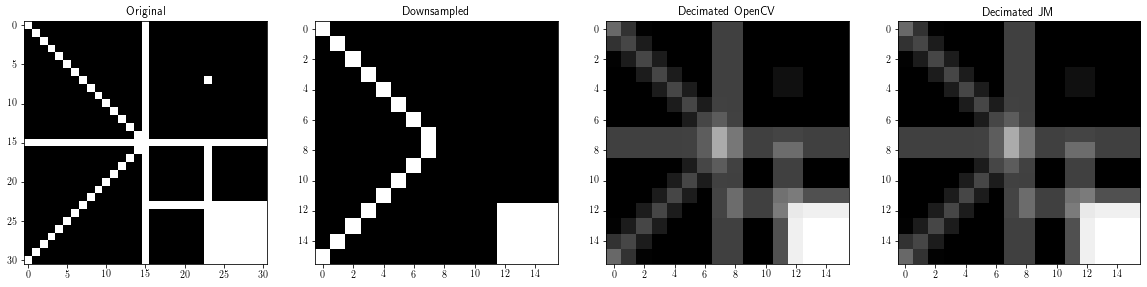

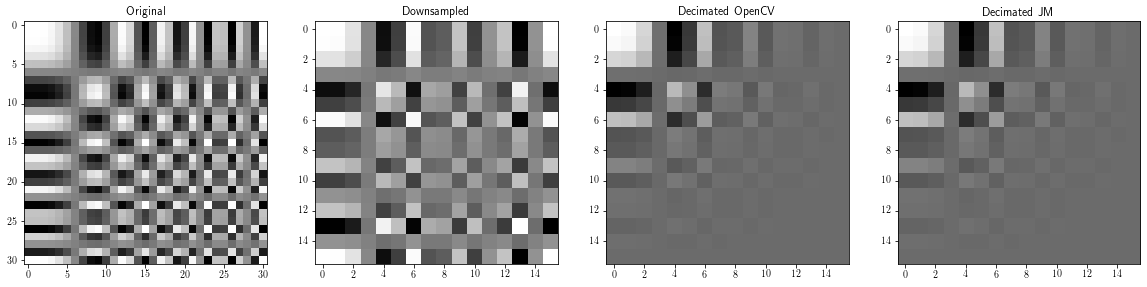

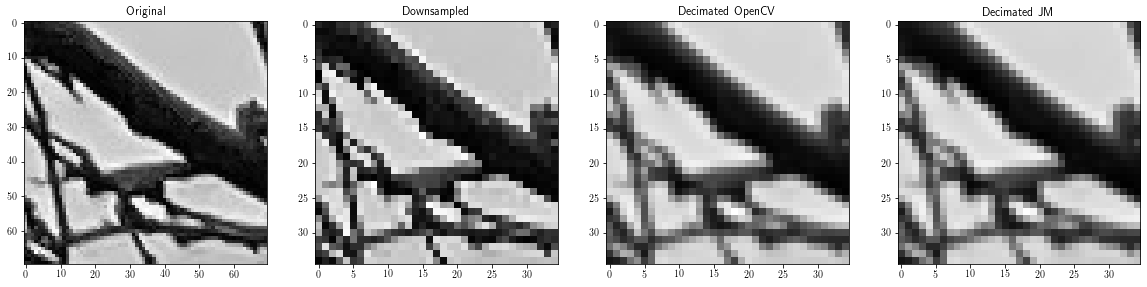

In [27]:
# kernelName = 'JPEG20009'
kernelName = 'OpenCV'

for cImage in range(4):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=7)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=31)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=31)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]

    downsampled = image[::2,::2]
    decimatedCV = cv.pyrDown(image)
    decimatedJM = DownsampleImage(image,kernelName=kernelName)
        
    figure = plt.figure()
    figure.set_size_inches(20,7)
    figure.clf()
    
    axes = figure.add_subplot(1,4,1)
    axes.imshow(image,cmap='gray')
    axes.set_title('Original')

    axes = figure.add_subplot(1,4,2)
    axes.imshow(downsampled,cmap='gray')
    axes.set_title('Downsampled')
    
    axes = figure.add_subplot(1,4,3)
    axes.imshow(decimatedCV,cmap='gray')
    axes.set_title('Decimated OpenCV')
    
    axes = figure.add_subplot(1,4,4)
    axes.imshow(decimatedJM,cmap='gray')
    axes.set_title('Decimated JM')

    plt.show()

    # OpenCV decimation (binary) is smoother than JPEG but less aliasing and 
    # JPEG errs on the side of harder edges and a little more aliasing.

### pyrDown Observations
* Not nearly as much of a difference as compared to interpolation
* Flat regions are not much of a problem
* pyrDown smooths more than the kernels that are used most frequently

# Image Pyramids

* In practice, elements of images can occur at a variety of scales
* Our algorithms need to be able to work at all these different scales
* Imagine a photo with an object that is far away, and another image in which the object occupies the entire frame
* Since these are both of the same object, but they are at very different resolutions, how do we compare them?


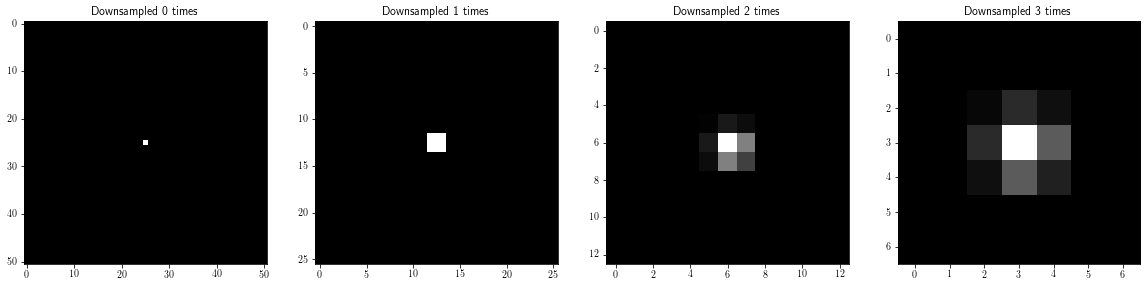

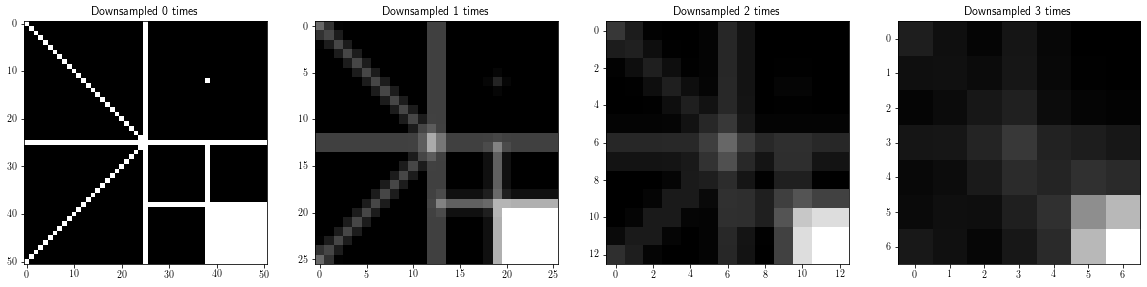

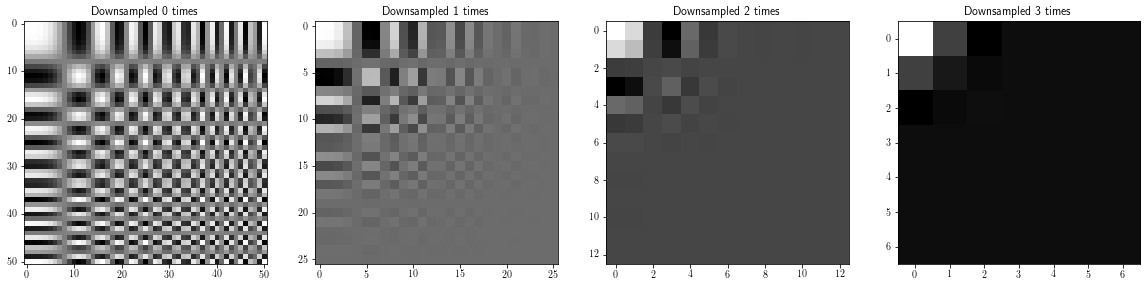

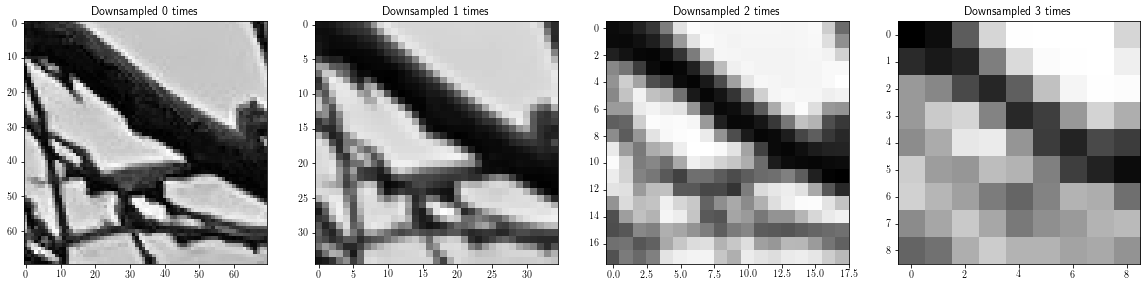

In [28]:
nImages = 4

for cImage in range(nImages):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=51)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=51)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=51)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    figure = plt.figure()
    figure.set_size_inches(20,5)
    figure.clf()
    
    for cDownsample in range(4):
        axes = figure.add_subplot(1,4,cDownsample+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Downsampled %d times' % (cDownsample))
        image = DownsampleImage(image,kernelName=kernelName)

    plt.show()

### Up and Down in Scale
* Of course, we can upsample downsampled images
* We can go up and down in scale


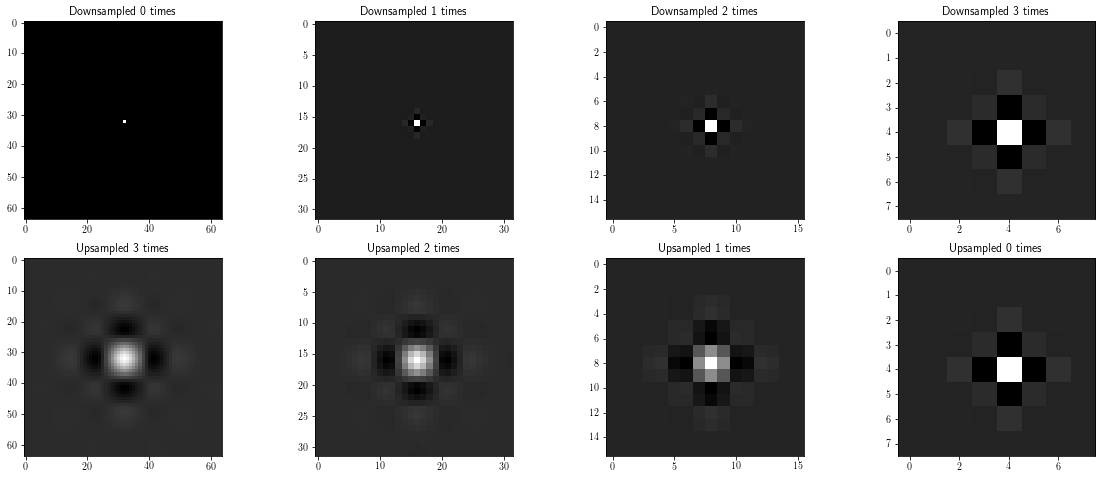

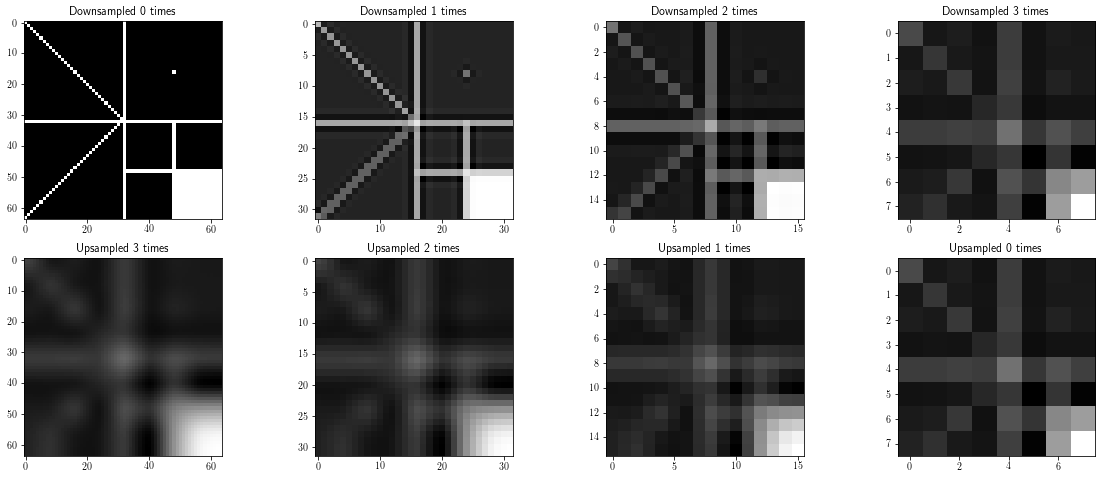

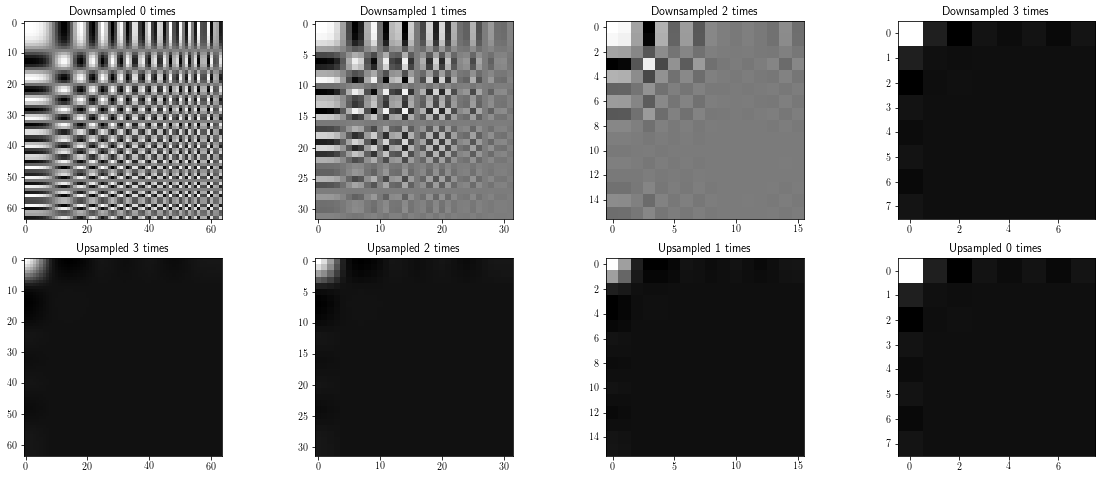

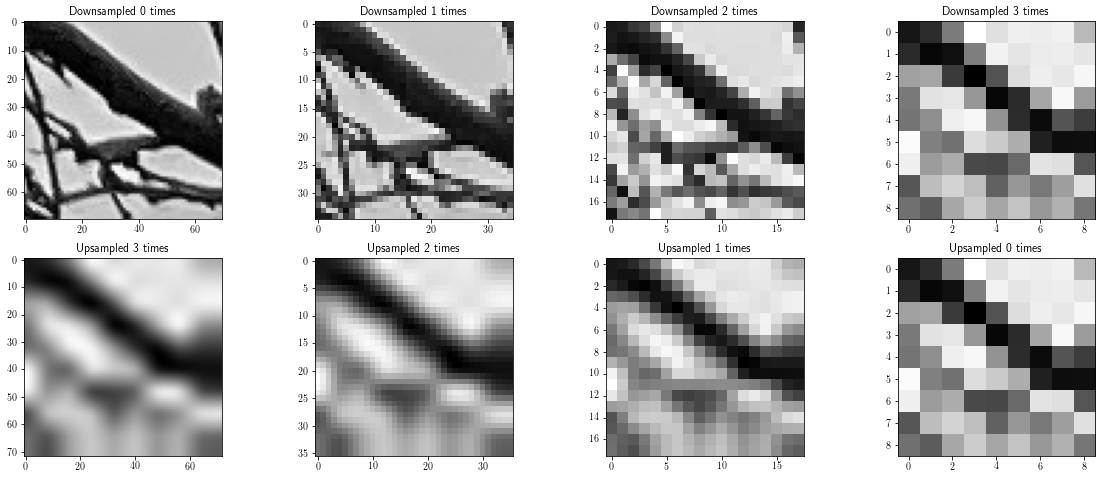

In [29]:
nImages = 4

for cImage in range(nImages):
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=2**6)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=2**6)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=2**6)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:220,150:220]
    figure = plt.figure()
    figure.set_size_inches(20,8)
    figure.clf()
    
    for cDownsample in range(4):
        axes = figure.add_subplot(2,4,cDownsample+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Downsampled %d times' % (cDownsample))
        if cDownsample==3:
            break
        image = DownsampleImage(image)
        
    for cUpsample in range(4):
        axes = figure.add_subplot(2,4,4+(3-cUpsample)+1)
        axes.imshow(image,cmap='gray')
        axes.set_title('Upsampled %d times' % (cUpsample))
        image = UpsampleImage(image,2) 
            
    plt.show()

### Laplacian Pyramids

* Its desirable in constructing a pyramid to be able to perfectly reconstruct the image
* These pyramids are sometimes called _self inverting_
* One way to do this is to calculate a residual and save it 
* Similar in principle to a difference of Gaussians
* Note that its actually a misnomer to called these pyramids Laplacian, since they are actually differences of approximate Gaussians
* But as with many ideas in computer vision, its close enough



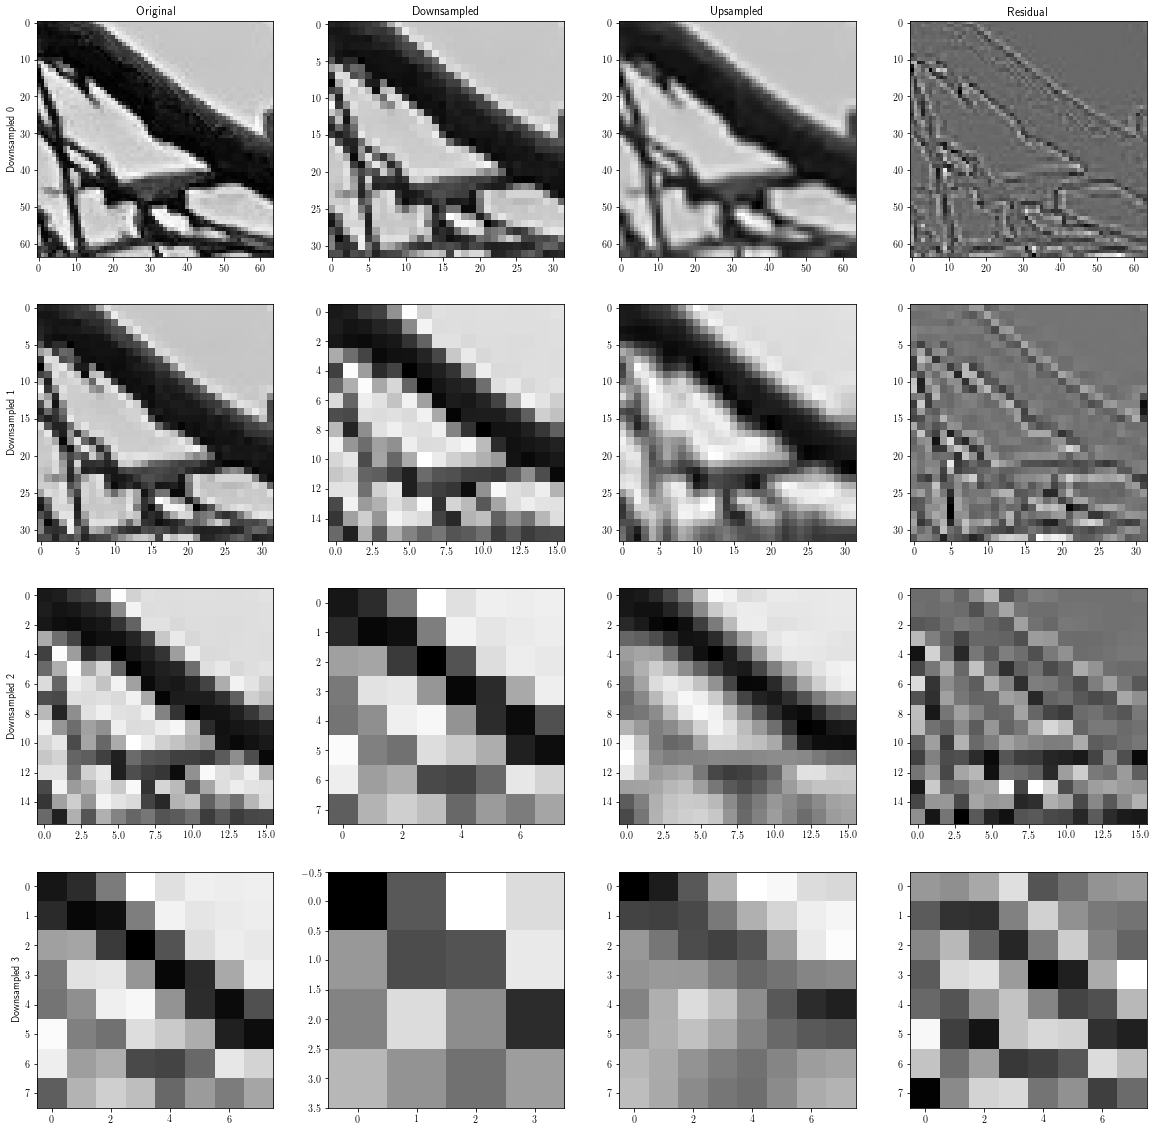

In [30]:
images = range(nImages)
images = [3]

nImages = len(images)

for cImage in images:
    if cImage==0:
        image = GetImpulseImage(nPixelsPerSide=2**6)
    elif cImage==1:
        image = GetTestImage(nPixelsPerSide=2**6)
    elif cImage==2:
        image = GetChirpImage(nPixelsPerSide=2**6)        
    else:
        image = cv.imread('DarkTree.jpeg',cv.IMREAD_GRAYSCALE)
        image = image[150:(150+2**6),150:(150+2**6)]
    figure = plt.figure()
    figure.set_size_inches(20,20)
    figure.clf()
    
    for cDownsample in range(4):
        downsampled = DownsampleImage(image)
        upsampled   = UpsampleImage(downsampled)
        residual    = image - upsampled
        
        axes = figure.add_subplot(4,4,cDownsample*4+1)
        axes.imshow(image,cmap='gray')
        axes.set_ylabel('Downsampled %d' % cDownsample)
        if cDownsample==0:
            axes.set_title('Original')
        
        axes = figure.add_subplot(4,4,cDownsample*4+2)
        axes.imshow(downsampled,cmap='gray') 
        if cDownsample==0:
            axes.set_title('Downsampled')
        
        axes = figure.add_subplot(4,4,cDownsample*4+3)
        axes.imshow(upsampled,cmap='gray')
        if cDownsample==0:
            axes.set_title('Upsampled')
        
        axes = figure.add_subplot(4,4,cDownsample*4+4)
        axes.imshow(residual,cmap='gray')
        if cDownsample==0:
            axes.set_title('Residual')        
        
        image = downsampled
            
    plt.show()

    # First we downsample the image by 2 and then upsample the downsampled image by 2
    # Residual is the difference between the upsampled and the original image
    # we can recreate the original by adding the residual to the upsampled image

    # If we had all the residuals, even after doing this downsampling/upsampling process
    # multiple times, we can recreate the original image

    # i.e. take "downsampled 3" upsampled image plus its residual gives us
    # "downsampled 2" upsampled. Add its residual gives us "downsampled 1". Add
    # its residual gives us "downsampled 0" upsampled. Plus its residual gives us
    # original image.

    # We want to change the scale to lower computation for computer vision
    # the algorithm may only need a lower resolution to recognize features.

    # Smoothing and then taking residual is another approach but you can't
    # recreate the original image. Saves a step.


### Image Pyramid Extensions

* Pyramids with levels separated by a full downsample factor of 2 are sometimes called _octave pyramids_
* It is possible to instead do multiple degrees of smoothing before getting to the point where you can decimate by a factor of 2
* For example, if using a Gaussian (or approximation), the standard deviation could be increased at each level by $\sqrt{2}$
* These are called _half octave_ pyramids
    * Also called difference of low-pass (DOLP) transforms
* There are also variations that sample with a checkerboard pattern, rather than a grid
    * Called _quincunx sampling_
* It is also possible to do this with wavelets
* As mentioned previously, the degree of smoothing (and decimating to save computation, if you like), can be thought of as the scale of the image
    * High-frequency features are removed
    * Smooth features are retained
* This is like looking at the image in another dimension (roughly analagous to the amount of zoom)
* Thus, we can think of images as having three continuous dimensions
    * Two spatial coordinates (again, think of as a surface, rather than a collection of pixels)
    * Spatial dimension
* If we add video, this takes us into 4 dimensions with the fourth dimension being time

